In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery

img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [10]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [11]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [13]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [14]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [15]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

### call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11(pretrained=False)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


# record time for one epoch
t0 = time.time()
for epoch in range(24):
    te = time.time()
    
    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs_, targets_) in enumerate(tl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = model(inputs)

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1


        if i%20 == 0: # print/store every 10
            losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
    
    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

    losses_ep.append(losses)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Let's use 4 GPUs!
batchsize,  8
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 207.72968459129333 seconds
on epoch 2
epoch: 2, LOSS=0.9377733469009399, ROC_AUC=0.8797664192766852 
time for epoch 2: 157.4432668685913 seconds
on epoch 3
time for epoch 3: 159.41878294944763 seconds
on epoch 4
epoch: 4, LOSS=0.8228312730789185, ROC_AUC=0.9034856527906009 
time for epoch 4: 160.04474520683289 seconds
on epoch 5
time for epoch 5: 159.45859742164612 seconds
on epoch 6
epoch: 6, LOSS=0.7154562473297119, ROC_AUC=0.9261219661941228 
time for epoch 6: 168.809246301651 seconds
on epoch 7
time for epoch 7: 159.77714085578918 seconds
on epoch 8
epoch: 8, LOSS=0.6265294551849365, ROC_AUC=0.9428020383537303 
time for epoch 8: 161.440274477005 seconds
on epoch 9
time for epoch 9: 161.60750770568848 seconds
on epoch 10
epoch: 10, LOSS=0.5612536668777466, ROC_AUC=0.9545717934763778 
time for epoch 10: 160.44924926757812 seconds
on epoch 11
time for epoch 11: 168.4453146457672 seconds
on epoch 12
epoch: 12, LOSS=0.5173080563545227, ROC_AUC=0.9621688060328406 
time 

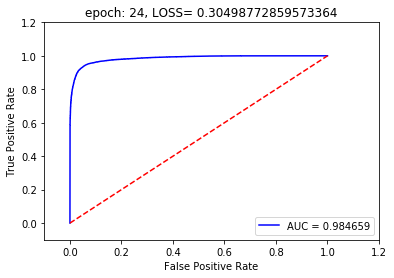

In [16]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [17]:
model.eval()

DataParallel(
  (module): UNet11(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Validation batch: 0, LOSS=0.43526744842529297, ROC_AUC=0.9688129591657229 


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


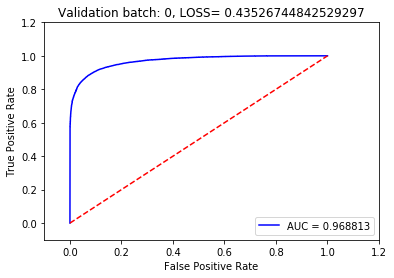

Validation batch: 1, LOSS=0.5066032409667969, ROC_AUC=0.9633333469598709 


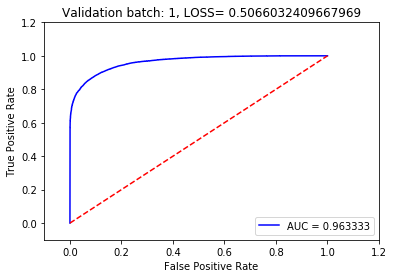

Validation batch: 2, LOSS=0.3633362352848053, ROC_AUC=0.9741482109563119 


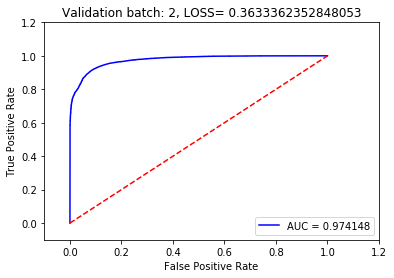

Validation batch: 3, LOSS=0.5737414956092834, ROC_AUC=0.9526056803703201 


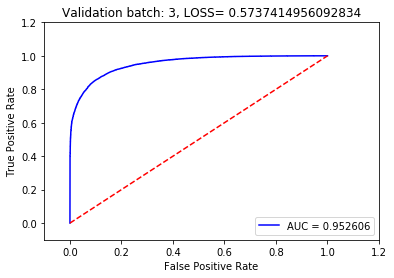

Validation batch: 4, LOSS=0.3453652858734131, ROC_AUC=0.9787976298483838 


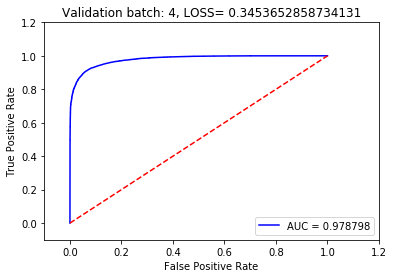

Validation batch: 5, LOSS=0.4698546826839447, ROC_AUC=0.960129374016959 


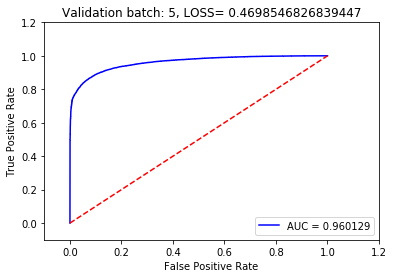

Validation batch: 6, LOSS=0.5660433769226074, ROC_AUC=0.9586239911654993 


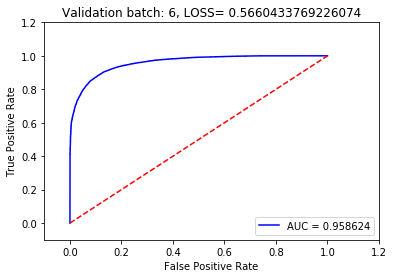

Validation batch: 7, LOSS=0.40595942735671997, ROC_AUC=0.9666514076195076 


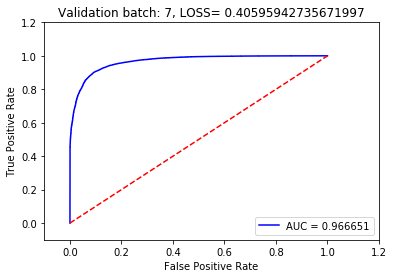

Validation batch: 8, LOSS=0.48280394077301025, ROC_AUC=0.9636407241429168 


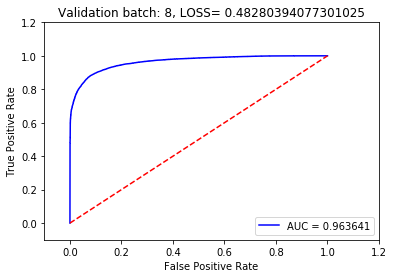

Validation batch: 9, LOSS=0.4732501804828644, ROC_AUC=0.9625028056084135 


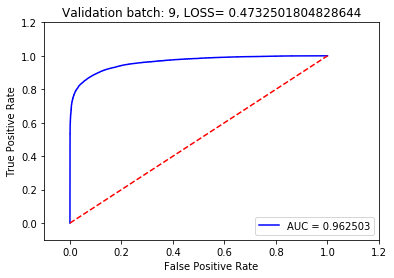

Validation batch: 10, LOSS=0.6800116896629333, ROC_AUC=0.937993501275448 


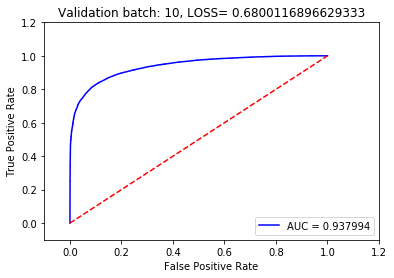

Validation batch: 11, LOSS=0.38032203912734985, ROC_AUC=0.9686386371313287 


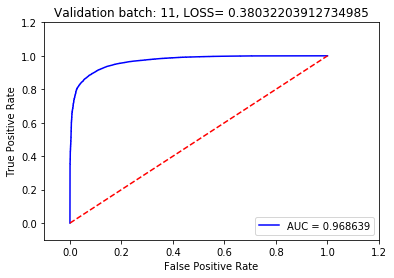

Validation batch: 12, LOSS=0.37664344906806946, ROC_AUC=0.9791083247582179 


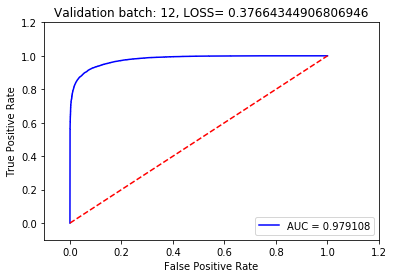

Validation batch: 13, LOSS=0.5116814374923706, ROC_AUC=0.9581811330755365 


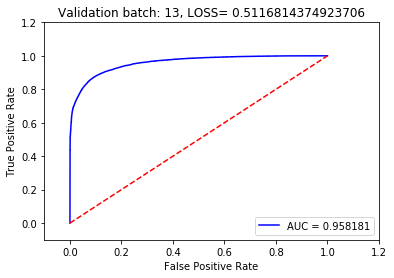

Validation batch: 14, LOSS=0.6115332245826721, ROC_AUC=0.952103537566985 


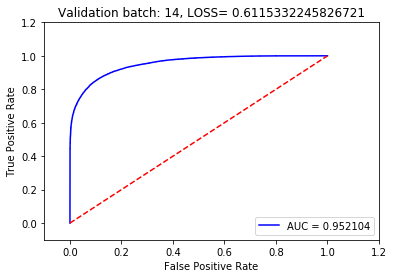

Validation batch: 15, LOSS=0.48020872473716736, ROC_AUC=0.967049562889516 


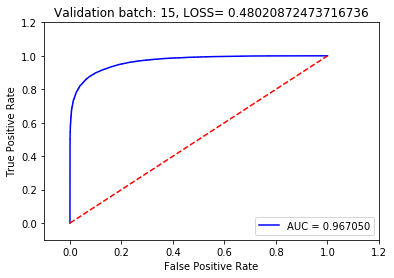

Validation batch: 16, LOSS=0.5429775714874268, ROC_AUC=0.9550845993515359 


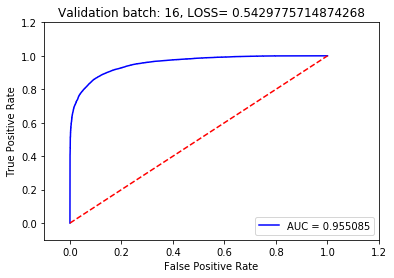

Validation batch: 17, LOSS=0.6741248369216919, ROC_AUC=0.9432469592375389 


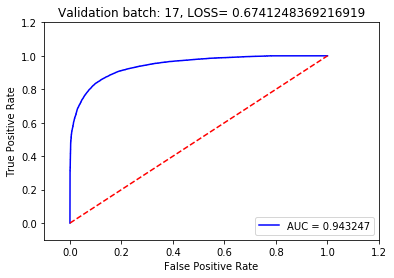

Validation batch: 18, LOSS=0.41439634561538696, ROC_AUC=0.9747635881371108 


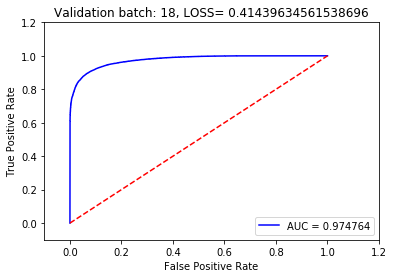

Validation batch: 19, LOSS=0.7745307683944702, ROC_AUC=0.9251852411557828 


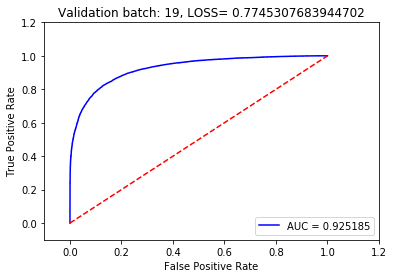

Validation batch: 20, LOSS=0.5393482446670532, ROC_AUC=0.9610373740272956 


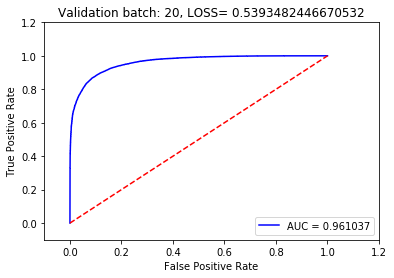

Validation batch: 21, LOSS=0.6104555130004883, ROC_AUC=0.9476143540204822 


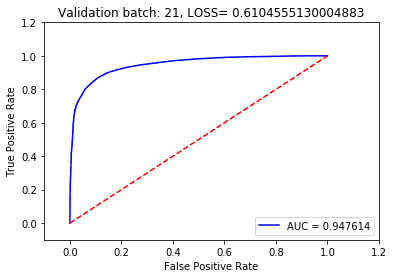

Validation batch: 22, LOSS=0.46445930004119873, ROC_AUC=0.9622675445366856 


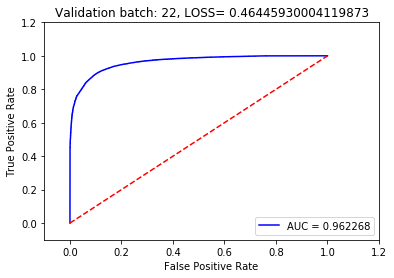

Validation batch: 23, LOSS=0.5387408137321472, ROC_AUC=0.9575531066475934 


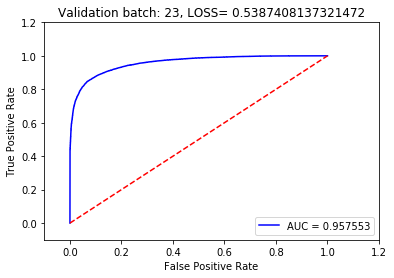

Validation batch: 24, LOSS=0.4858936071395874, ROC_AUC=0.96656141547752 


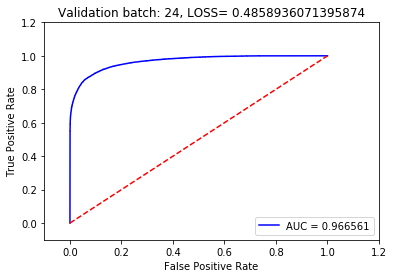

Validation batch: 25, LOSS=0.5512204766273499, ROC_AUC=0.956243273807204 


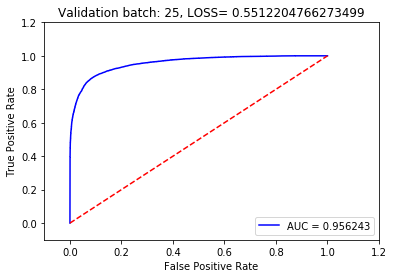

Validation batch: 26, LOSS=0.4547501802444458, ROC_AUC=0.9625796767541044 


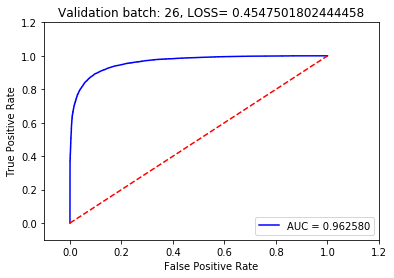

Validation batch: 27, LOSS=0.5941494107246399, ROC_AUC=0.9504063862714651 


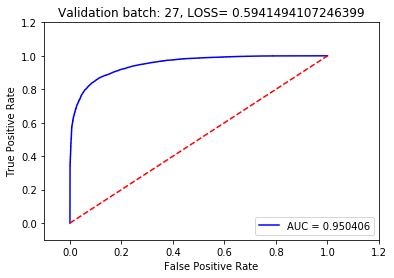

Validation batch: 28, LOSS=0.6680240035057068, ROC_AUC=0.9373821648564448 


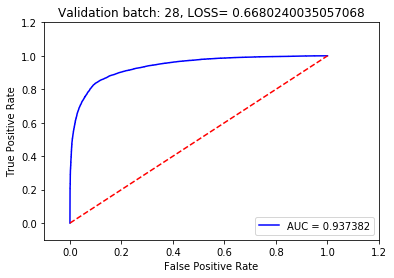

Validation batch: 29, LOSS=0.5626927018165588, ROC_AUC=0.9611326354539671 


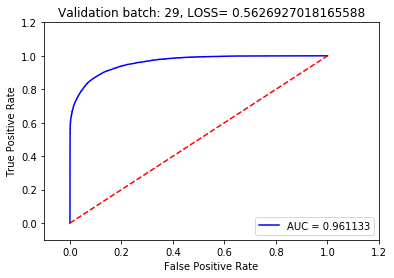

Validation batch: 30, LOSS=0.6160578727722168, ROC_AUC=0.9468714904334903 


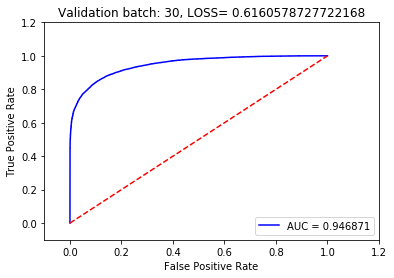

Validation batch: 31, LOSS=0.5671362280845642, ROC_AUC=0.953518597461126 


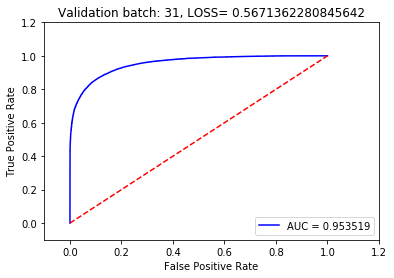

Validation batch: 32, LOSS=0.4880037307739258, ROC_AUC=0.968221747497185 


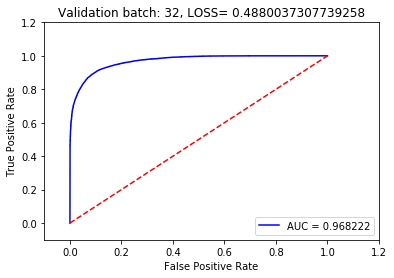

Validation batch: 33, LOSS=0.7652802467346191, ROC_AUC=0.9275993789405638 


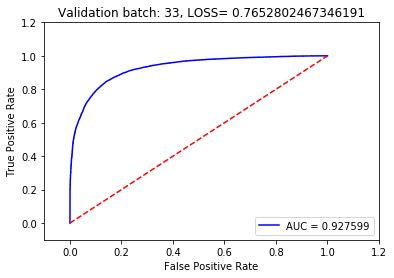

Validation batch: 34, LOSS=0.357255220413208, ROC_AUC=0.9707239137942343 


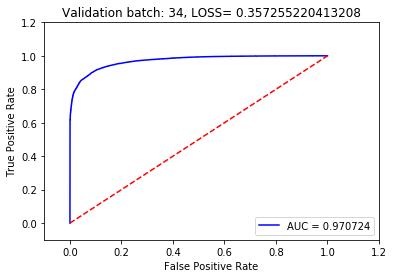

Validation batch: 35, LOSS=0.5546122789382935, ROC_AUC=0.9514042612716922 


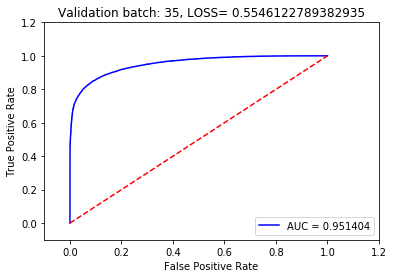

Validation batch: 36, LOSS=0.5044803619384766, ROC_AUC=0.9694185572273722 


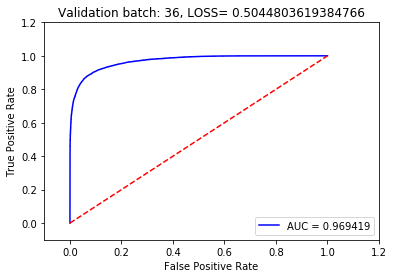

Validation batch: 37, LOSS=0.5410957336425781, ROC_AUC=0.9542030706870641 


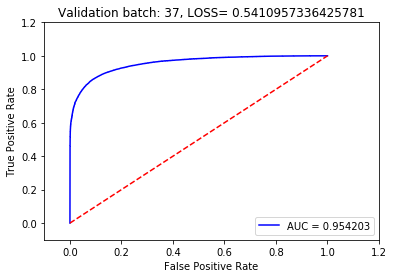

Validation batch: 38, LOSS=0.7223793268203735, ROC_AUC=0.9407674941083161 


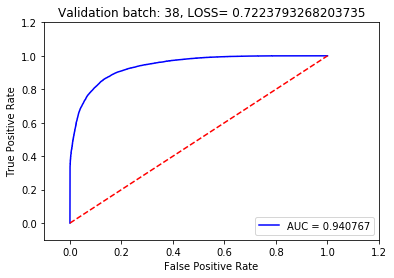

Validation batch: 39, LOSS=0.4169424772262573, ROC_AUC=0.9740782849730226 


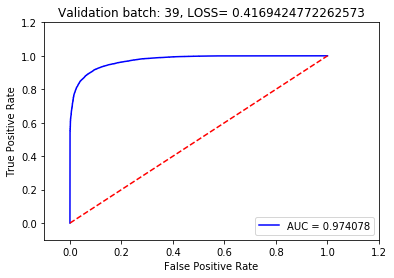

Validation batch: 40, LOSS=0.6446159482002258, ROC_AUC=0.9401352783055082 


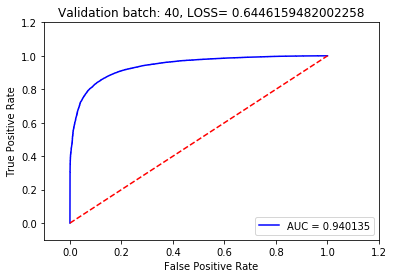

Validation batch: 41, LOSS=0.5508556962013245, ROC_AUC=0.9588131257644936 


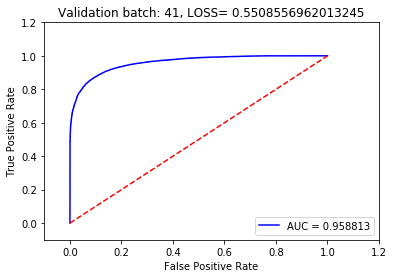

Validation batch: 42, LOSS=0.3827180862426758, ROC_AUC=0.9692407979767323 


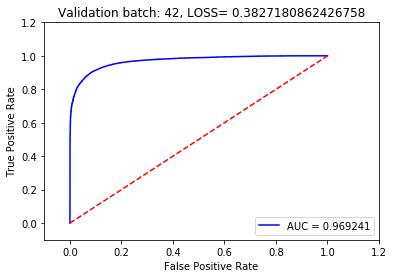

Validation batch: 43, LOSS=0.5396921634674072, ROC_AUC=0.9515751334897562 


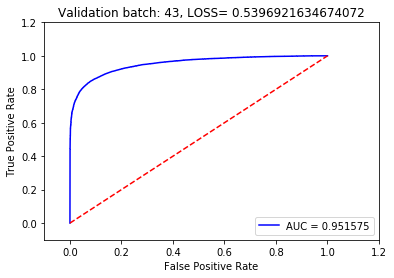

Validation batch: 44, LOSS=0.625282347202301, ROC_AUC=0.9504640175100016 


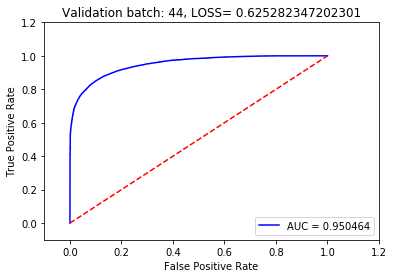

Validation batch: 45, LOSS=0.5897701978683472, ROC_AUC=0.9501758846013674 


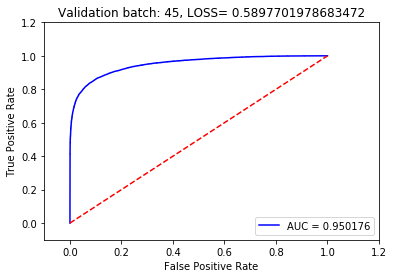

Validation batch: 46, LOSS=0.5651607513427734, ROC_AUC=0.9557179867611589 


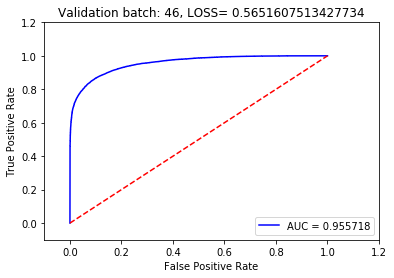

Validation batch: 47, LOSS=0.652678370475769, ROC_AUC=0.9432716892063908 


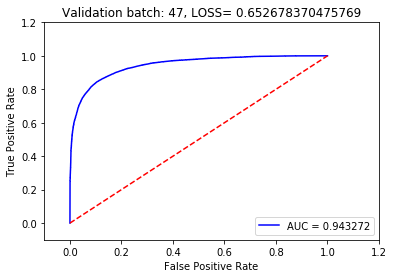

Validation batch: 48, LOSS=0.6012682318687439, ROC_AUC=0.9403313554256086 


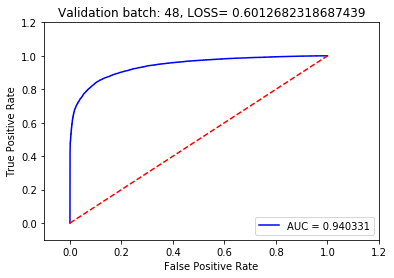

Validation batch: 49, LOSS=0.4265599846839905, ROC_AUC=0.970275658437041 


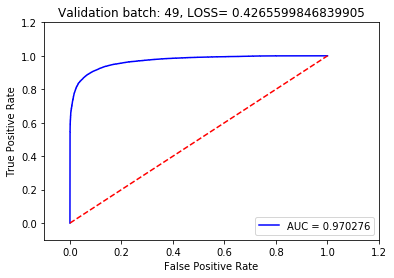

Validation batch: 50, LOSS=0.4782589077949524, ROC_AUC=0.9695576962031596 


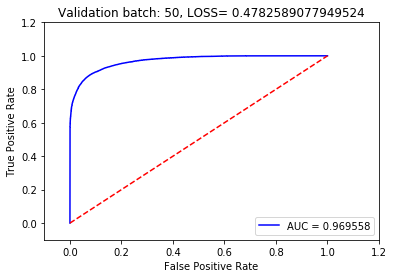

Validation batch: 51, LOSS=0.5562811493873596, ROC_AUC=0.9545762502775452 


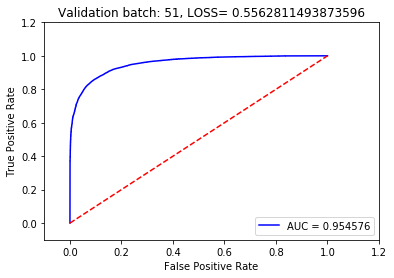

Validation batch: 52, LOSS=0.3936484456062317, ROC_AUC=0.9794165600381721 


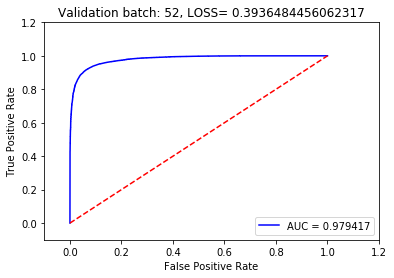

Validation batch: 53, LOSS=0.4967060089111328, ROC_AUC=0.9586143896851202 


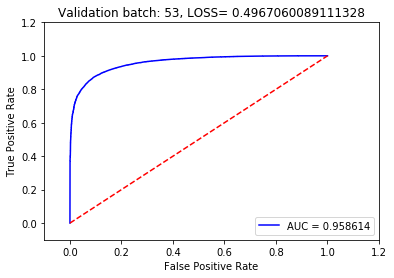

Validation batch: 54, LOSS=0.7445695996284485, ROC_AUC=0.9253008636038172 


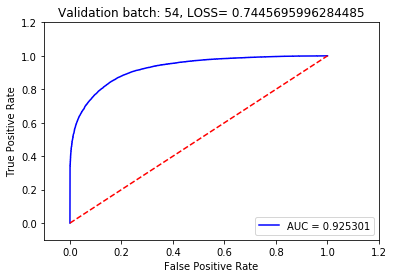

Validation batch: 55, LOSS=0.4585360288619995, ROC_AUC=0.965683167077841 


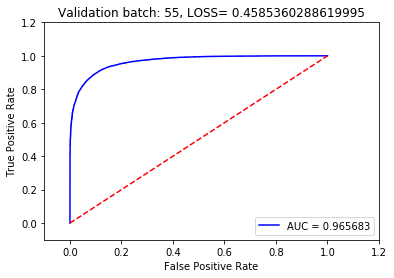

Validation batch: 56, LOSS=0.6087499856948853, ROC_AUC=0.9492958949278805 


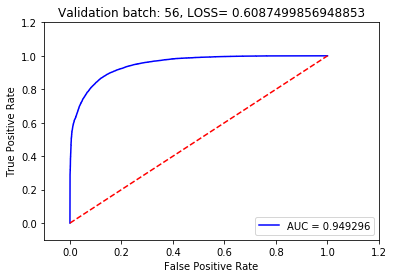

Validation batch: 57, LOSS=0.38824278116226196, ROC_AUC=0.9793971090892469 


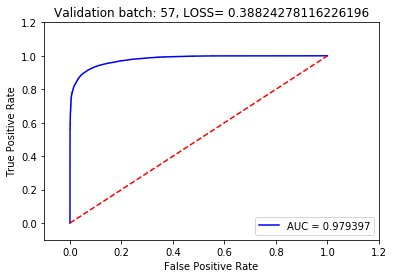

Validation batch: 58, LOSS=0.6348670721054077, ROC_AUC=0.9408498110757864 


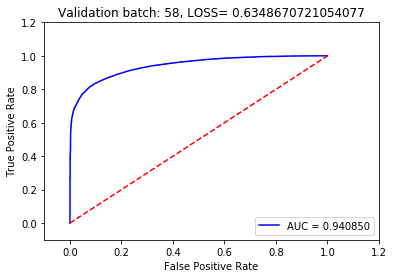

Validation batch: 59, LOSS=0.6157152652740479, ROC_AUC=0.9532963902043642 


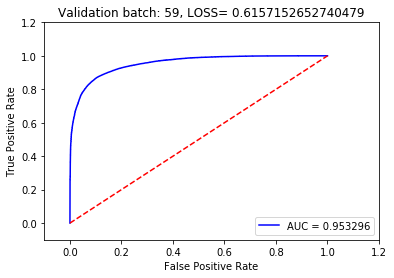

Validation batch: 60, LOSS=0.6519096493721008, ROC_AUC=0.9431380940785558 


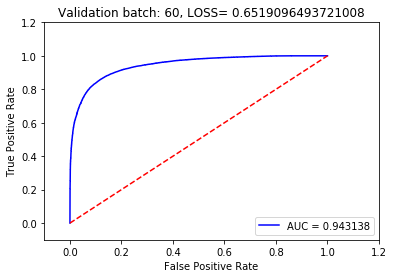

Validation batch: 61, LOSS=0.5155941843986511, ROC_AUC=0.9628095694465729 


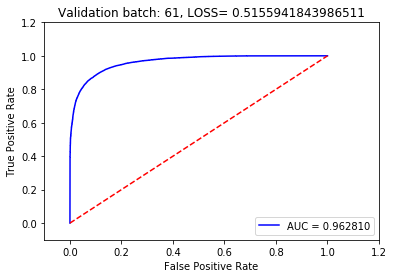

Validation batch: 62, LOSS=0.49281853437423706, ROC_AUC=0.9610589956368862 


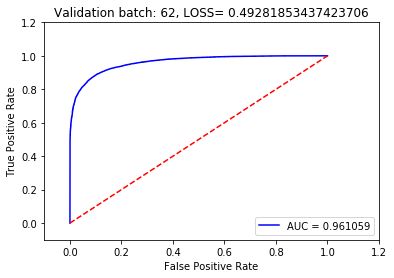

Validation batch: 63, LOSS=0.48030489683151245, ROC_AUC=0.9674802856318943 


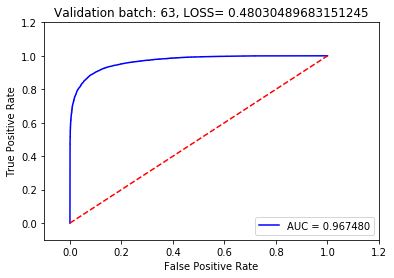

Validation batch: 64, LOSS=0.5461335778236389, ROC_AUC=0.9545823746243836 


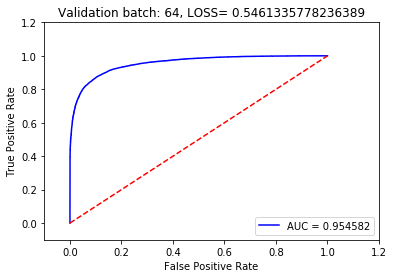

Validation batch: 65, LOSS=0.654260516166687, ROC_AUC=0.9395153765260922 


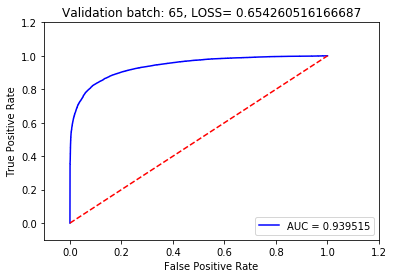

Validation batch: 66, LOSS=0.6229172348976135, ROC_AUC=0.9496966087442265 


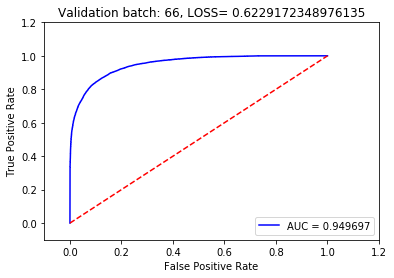

Validation batch: 67, LOSS=0.6900812387466431, ROC_AUC=0.9447110550905129 


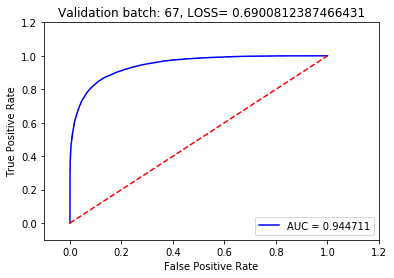

Validation batch: 68, LOSS=0.39713361859321594, ROC_AUC=0.972238743934379 


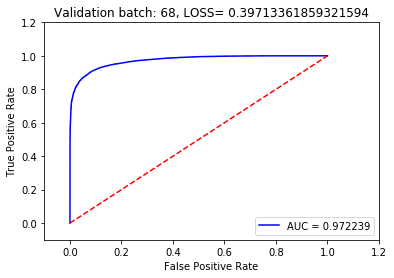

Validation batch: 69, LOSS=0.43188512325286865, ROC_AUC=0.9702818317959733 


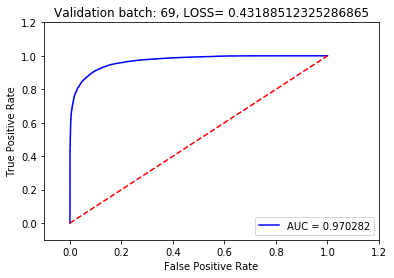

Validation batch: 70, LOSS=0.7546575665473938, ROC_AUC=0.9272934386737511 


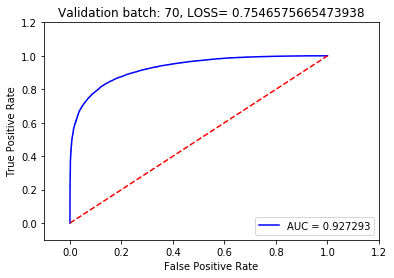

Validation batch: 71, LOSS=0.684380054473877, ROC_AUC=0.936769907100678 


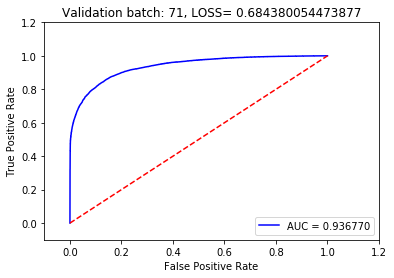

Validation batch: 72, LOSS=0.652812659740448, ROC_AUC=0.9456078667713111 


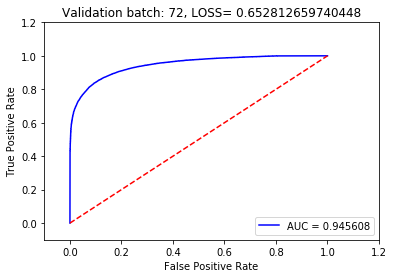

Validation batch: 73, LOSS=0.5663941502571106, ROC_AUC=0.953574370420464 


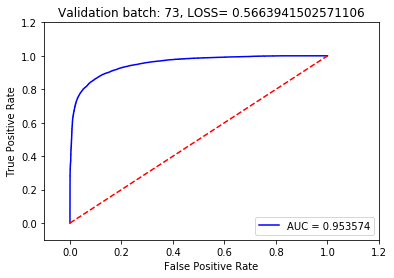

Validation batch: 74, LOSS=0.5976747274398804, ROC_AUC=0.9546199210322683 


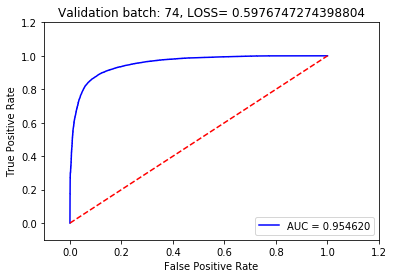

Validation batch: 75, LOSS=0.6369438171386719, ROC_AUC=0.9465084926114313 


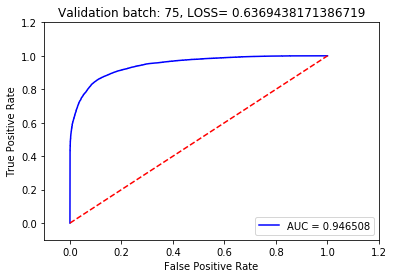

Validation batch: 76, LOSS=0.6097323894500732, ROC_AUC=0.9570874492694605 


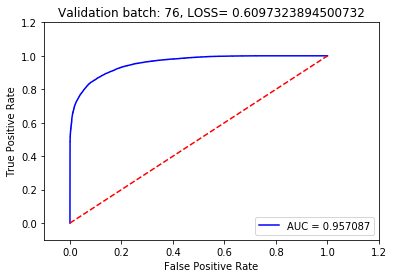

Validation batch: 77, LOSS=0.43073731660842896, ROC_AUC=0.9682784265643715 


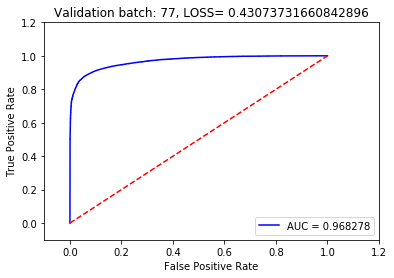

Validation batch: 78, LOSS=0.6171928644180298, ROC_AUC=0.9475017331808921 


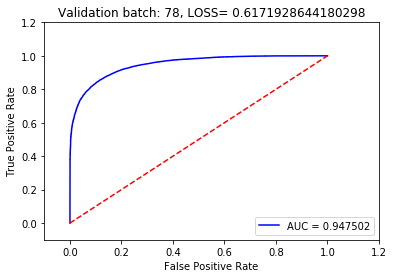

Validation batch: 79, LOSS=0.6940900087356567, ROC_AUC=0.936227150807877 


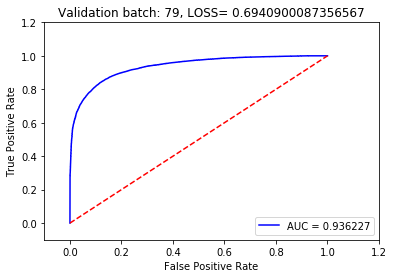

Validation batch: 80, LOSS=0.5034856796264648, ROC_AUC=0.9643212096555156 


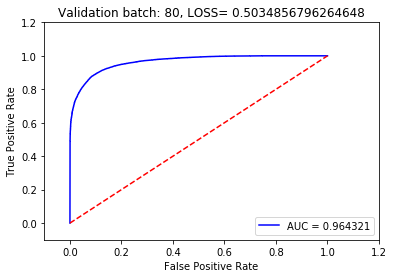

Validation batch: 81, LOSS=0.5596449971199036, ROC_AUC=0.9580088833560858 


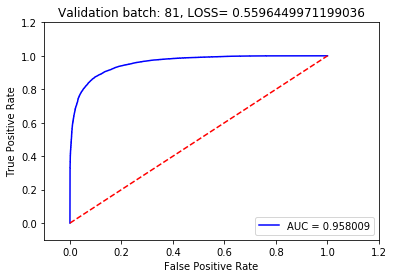

Validation batch: 82, LOSS=0.4853721857070923, ROC_AUC=0.9676953979086532 


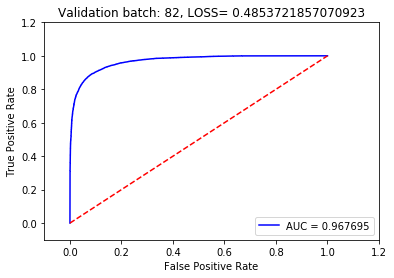

Validation batch: 83, LOSS=0.5961565971374512, ROC_AUC=0.9518372715050741 


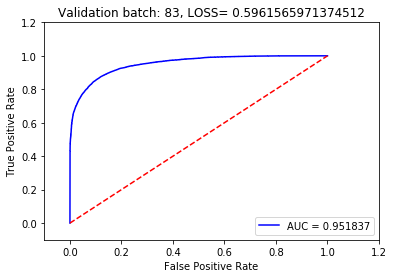

Validation batch: 84, LOSS=0.3165253698825836, ROC_AUC=0.9781621611983102 


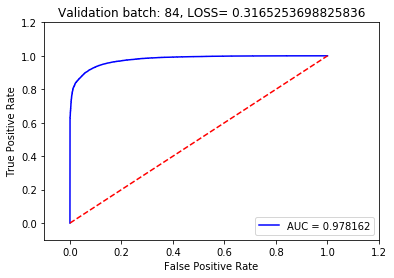

Validation batch: 85, LOSS=0.5476785898208618, ROC_AUC=0.9525146800321557 


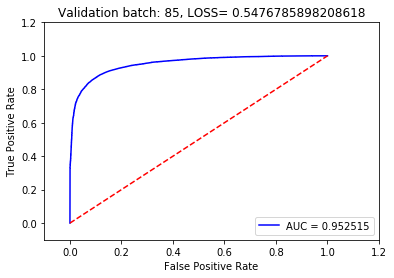

Validation batch: 86, LOSS=0.367625892162323, ROC_AUC=0.9722672657936551 


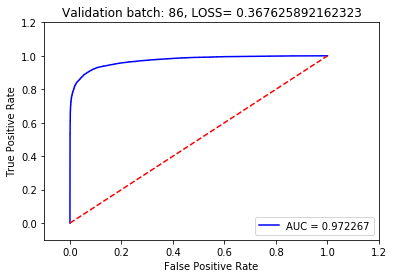

Validation batch: 87, LOSS=0.4205787181854248, ROC_AUC=0.9732233173496997 


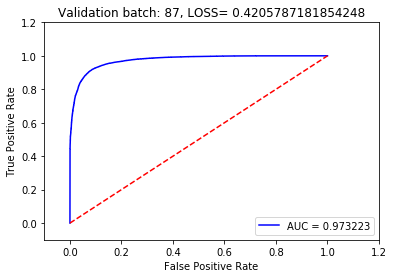

Validation batch: 88, LOSS=0.42876923084259033, ROC_AUC=0.9668433880048617 


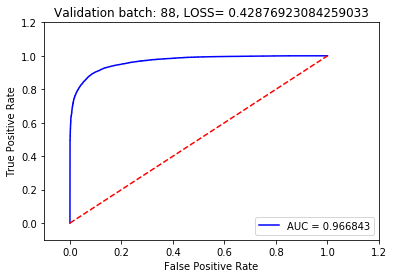

Validation batch: 89, LOSS=0.6829289197921753, ROC_AUC=0.9508370915933939 


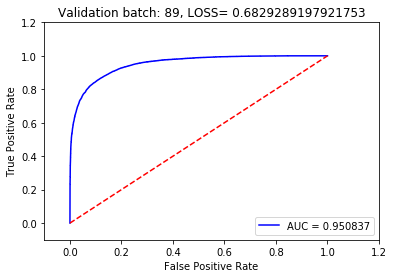

Validation batch: 90, LOSS=0.5374497175216675, ROC_AUC=0.9567131142757899 


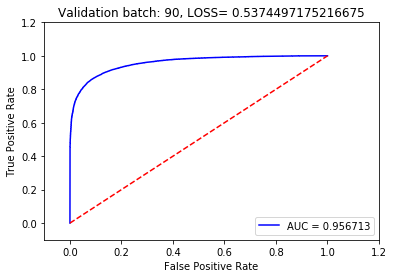

Validation batch: 91, LOSS=0.4462944269180298, ROC_AUC=0.968765826850383 


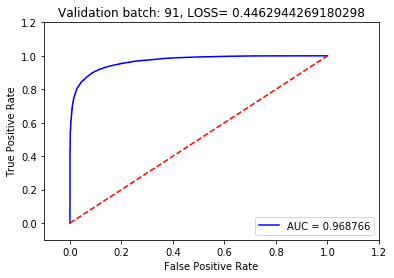

Validation batch: 92, LOSS=0.4489610195159912, ROC_AUC=0.9649141334691936 


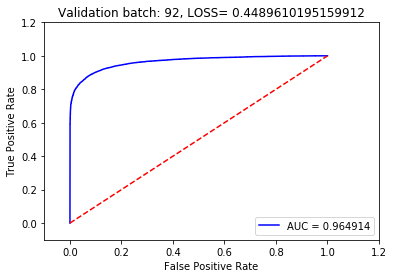

Validation batch: 93, LOSS=0.4879903197288513, ROC_AUC=0.9611942258471479 


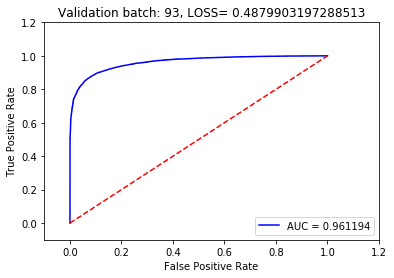

Validation batch: 94, LOSS=0.569482684135437, ROC_AUC=0.9538750788756039 


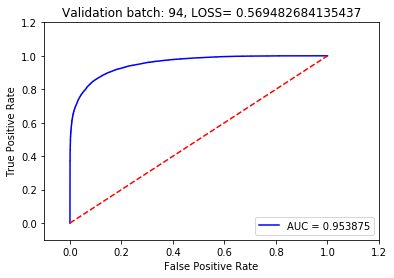

Validation batch: 95, LOSS=0.5211073160171509, ROC_AUC=0.9524999786433772 


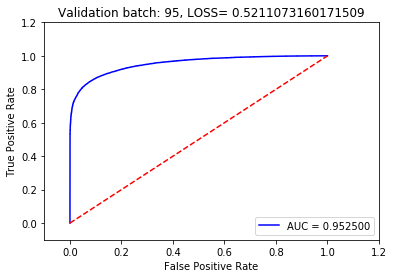

Validation batch: 96, LOSS=0.4632890522480011, ROC_AUC=0.9615696825798918 


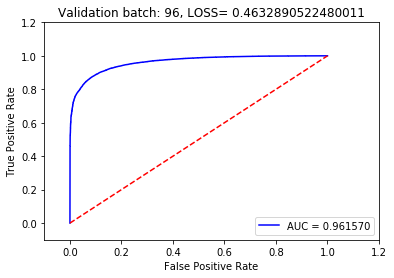

Validation batch: 97, LOSS=0.38985294103622437, ROC_AUC=0.9711556730696298 


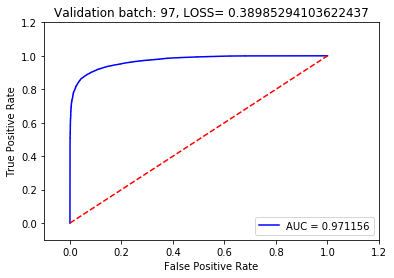

Validation batch: 98, LOSS=0.8221969604492188, ROC_AUC=0.914904616108932 


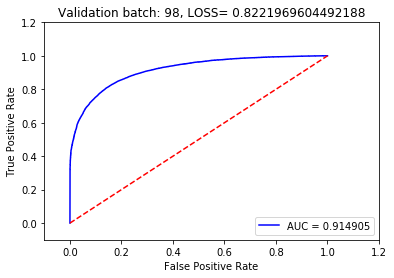

Validation batch: 99, LOSS=0.36974263191223145, ROC_AUC=0.9741782893779493 


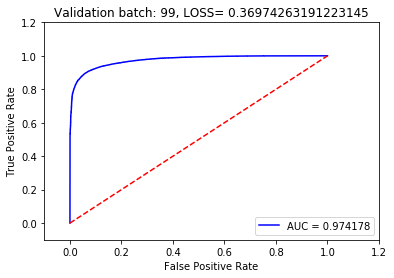

Validation batch: 100, LOSS=0.5106529593467712, ROC_AUC=0.9579669817385292 


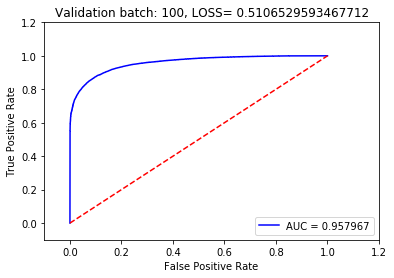

Validation batch: 101, LOSS=0.4039311110973358, ROC_AUC=0.9694150604704047 


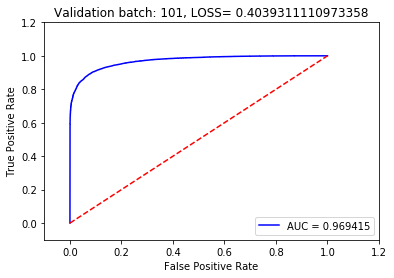

Validation batch: 102, LOSS=0.843539297580719, ROC_AUC=0.9243059342813555 


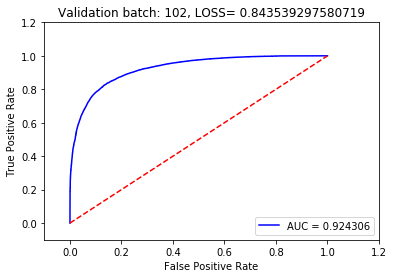

Validation batch: 103, LOSS=0.41765275597572327, ROC_AUC=0.9680900496182445 


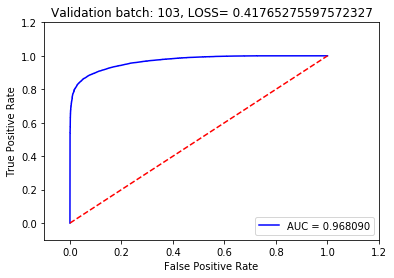

Validation batch: 104, LOSS=0.458304762840271, ROC_AUC=0.9689931197037643 


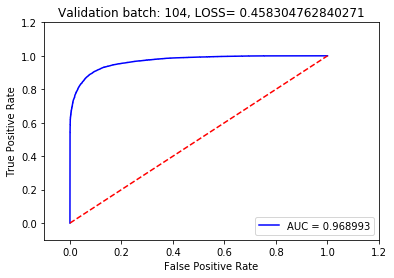

Validation batch: 105, LOSS=0.716998279094696, ROC_AUC=0.9360610812020002 


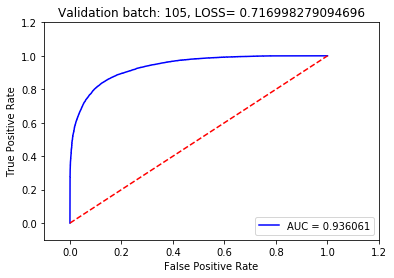

Validation batch: 106, LOSS=0.6555397510528564, ROC_AUC=0.9408588543167633 


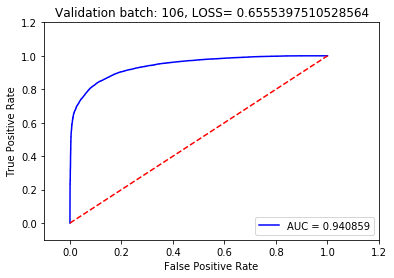

Validation batch: 107, LOSS=0.4533138871192932, ROC_AUC=0.9597197595176961 


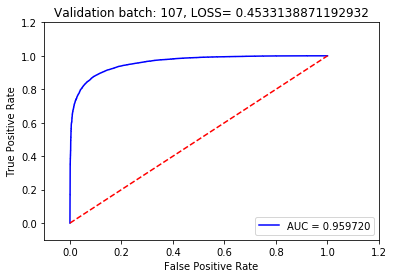

Validation batch: 108, LOSS=0.6838549375534058, ROC_AUC=0.939325553496948 


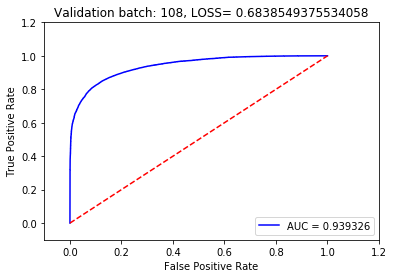

Validation batch: 109, LOSS=0.2530350387096405, ROC_AUC=0.9859485000873599 


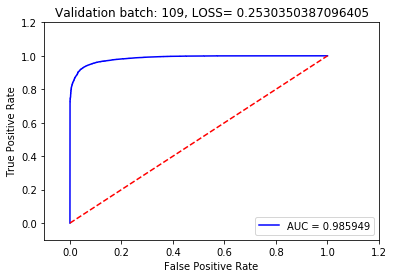

Validation batch: 110, LOSS=0.4265989661216736, ROC_AUC=0.9688081963420763 


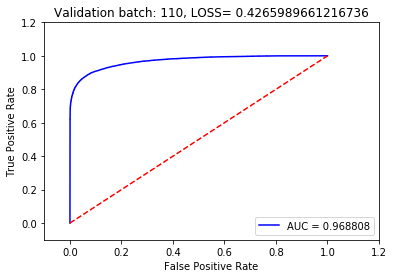

Validation batch: 111, LOSS=0.4585713744163513, ROC_AUC=0.9708495237047898 


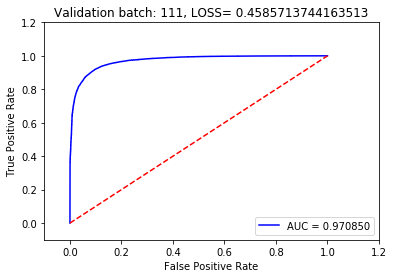

Validation batch: 112, LOSS=0.39002954959869385, ROC_AUC=0.9757528518276264 


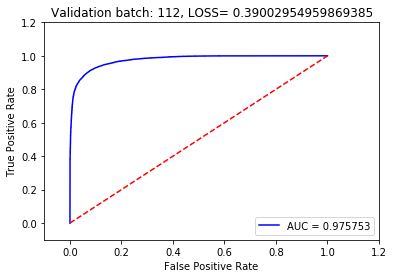

Validation batch: 113, LOSS=0.6035398244857788, ROC_AUC=0.9532841300889294 


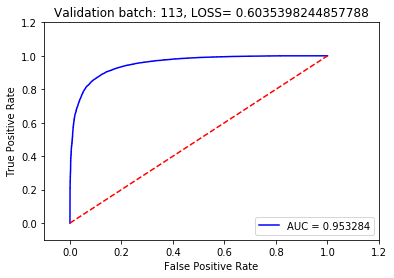

Validation batch: 114, LOSS=0.3941650688648224, ROC_AUC=0.9715893880123954 


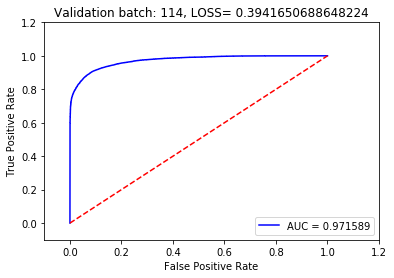

Validation batch: 115, LOSS=0.5774645805358887, ROC_AUC=0.9501475062789955 


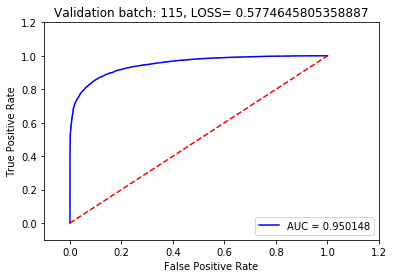

Validation batch: 116, LOSS=0.3978005051612854, ROC_AUC=0.9723334479006073 


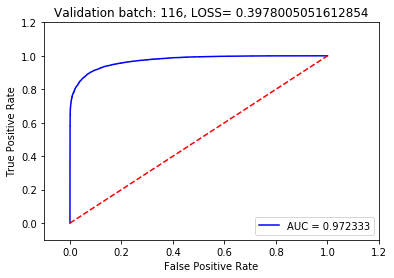

Validation batch: 117, LOSS=0.43533727526664734, ROC_AUC=0.9674487266474141 


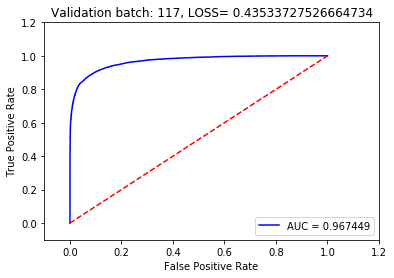

Validation batch: 118, LOSS=0.45790547132492065, ROC_AUC=0.9688132370262864 


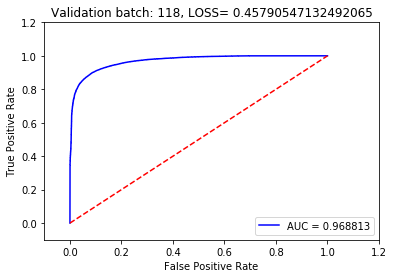

Validation batch: 119, LOSS=0.5584811568260193, ROC_AUC=0.9523339767882559 


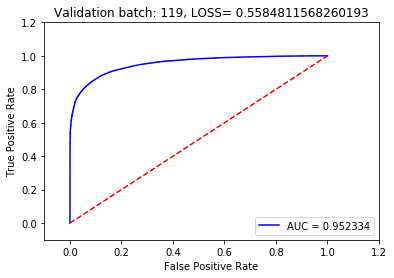

Validation batch: 120, LOSS=0.44171494245529175, ROC_AUC=0.9613959186187535 


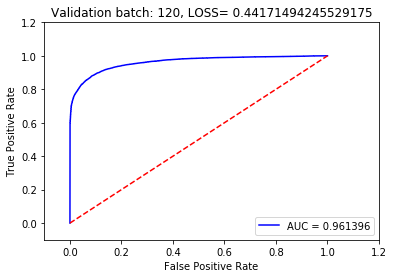

Validation batch: 121, LOSS=0.4885525107383728, ROC_AUC=0.9650854189922085 


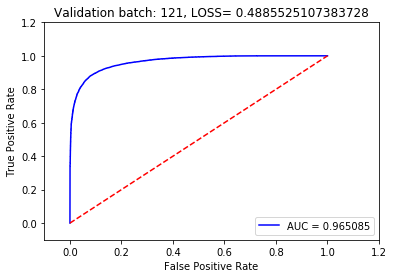

Validation batch: 122, LOSS=0.43857237696647644, ROC_AUC=0.9699017526756379 


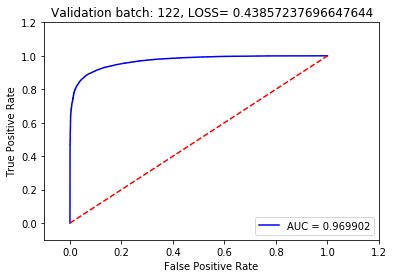

Validation batch: 123, LOSS=0.6121071577072144, ROC_AUC=0.9464869989885745 


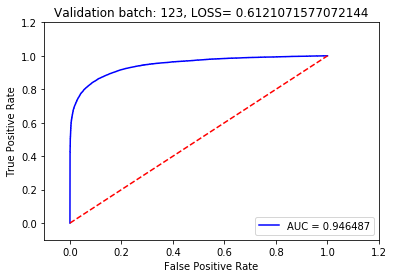

Validation batch: 124, LOSS=0.5077869892120361, ROC_AUC=0.9617470044906794 


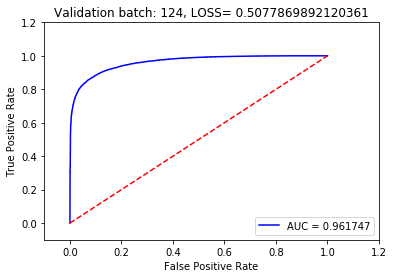

In [18]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





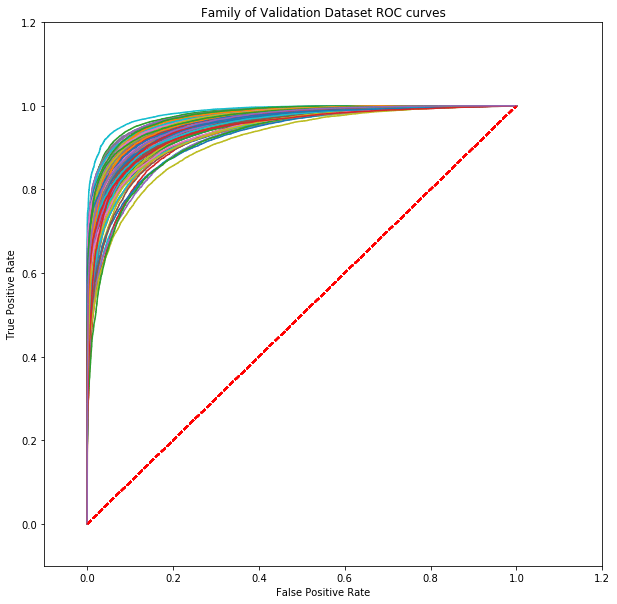

In [19]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

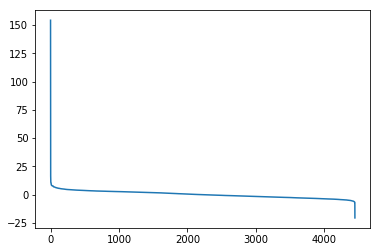

In [20]:
plt.plot(all_thresh[0])

In [21]:
model_path = 'runs/debug/model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

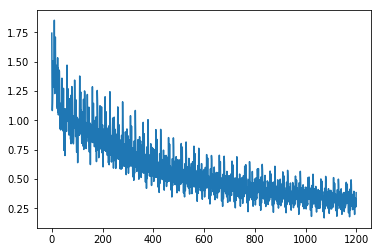

In [22]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


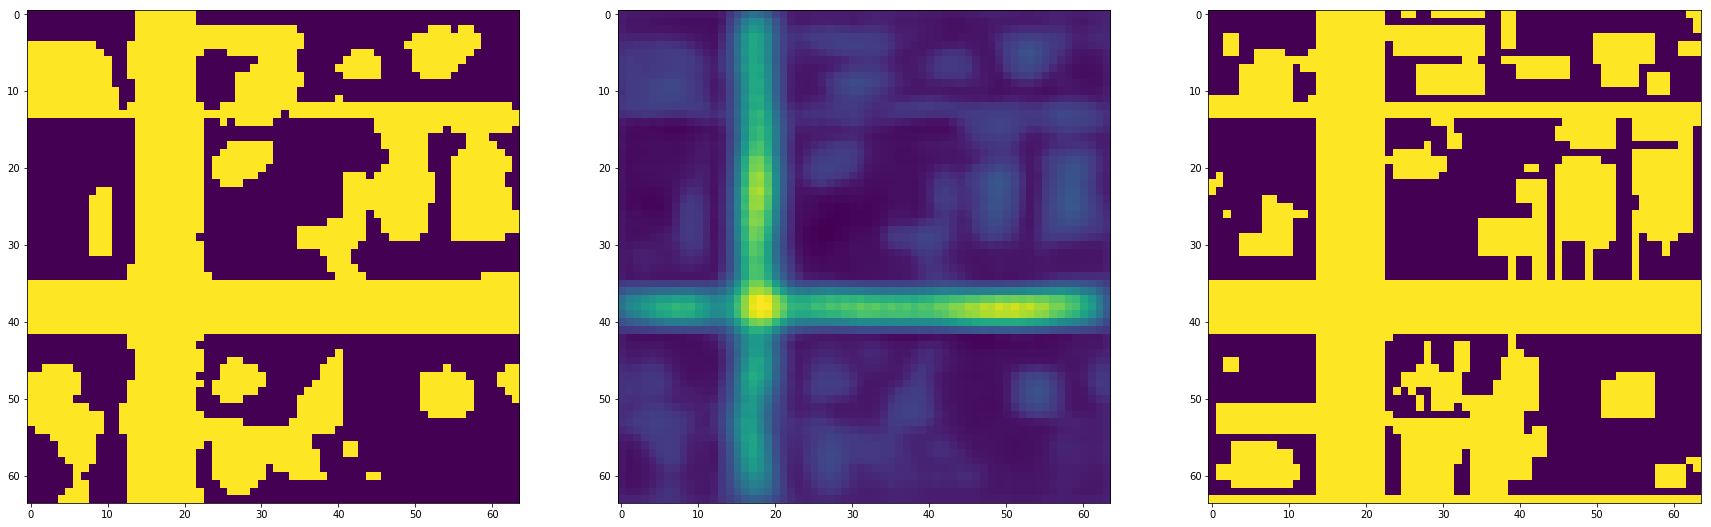

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


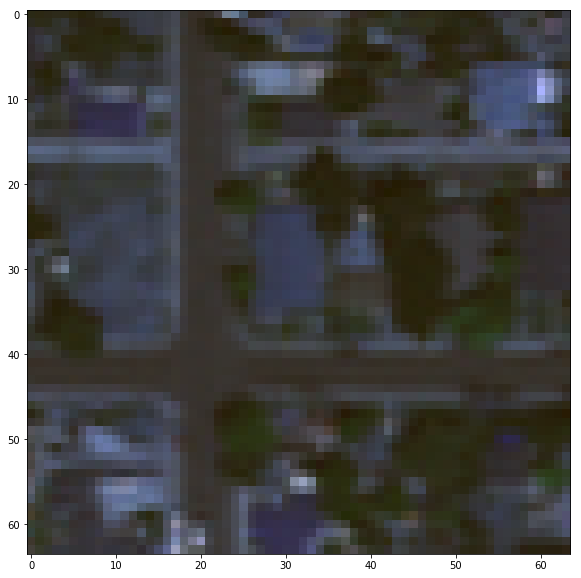

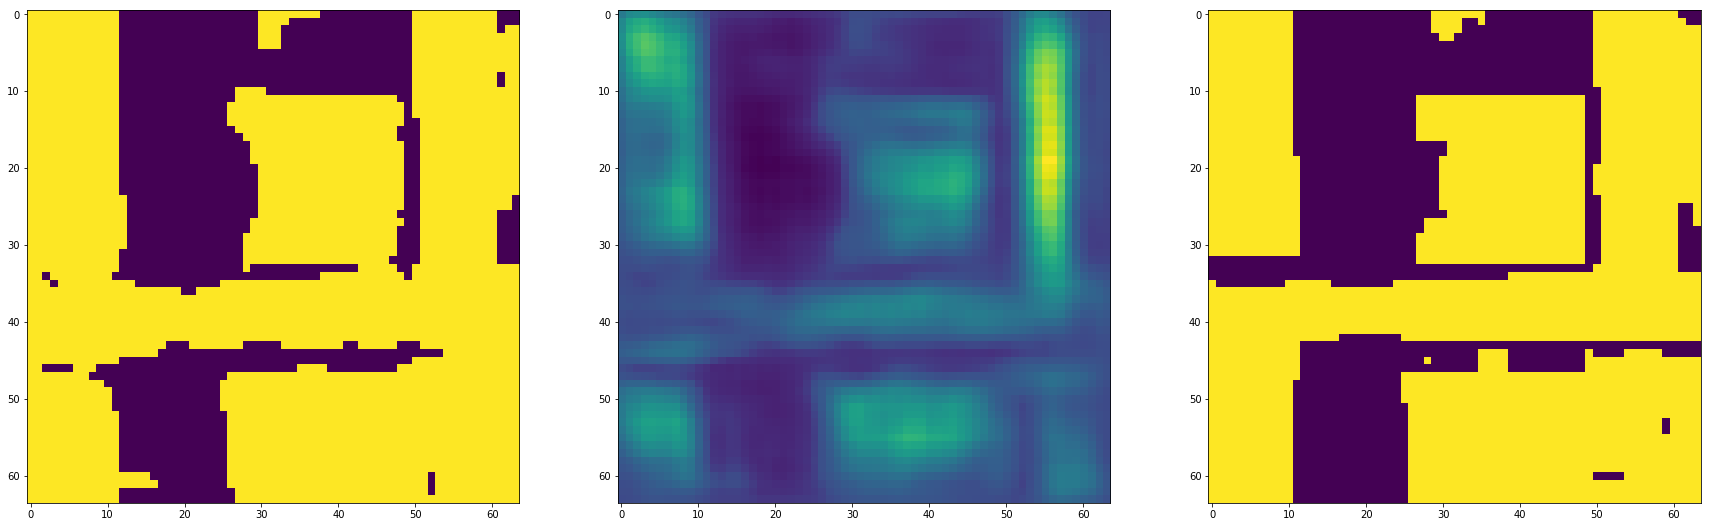

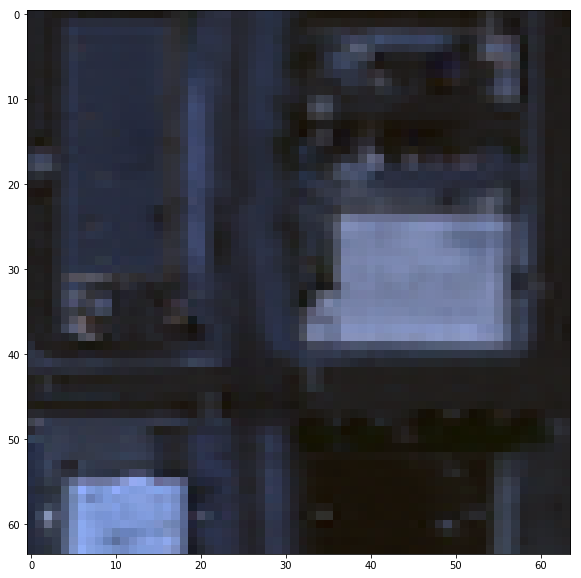

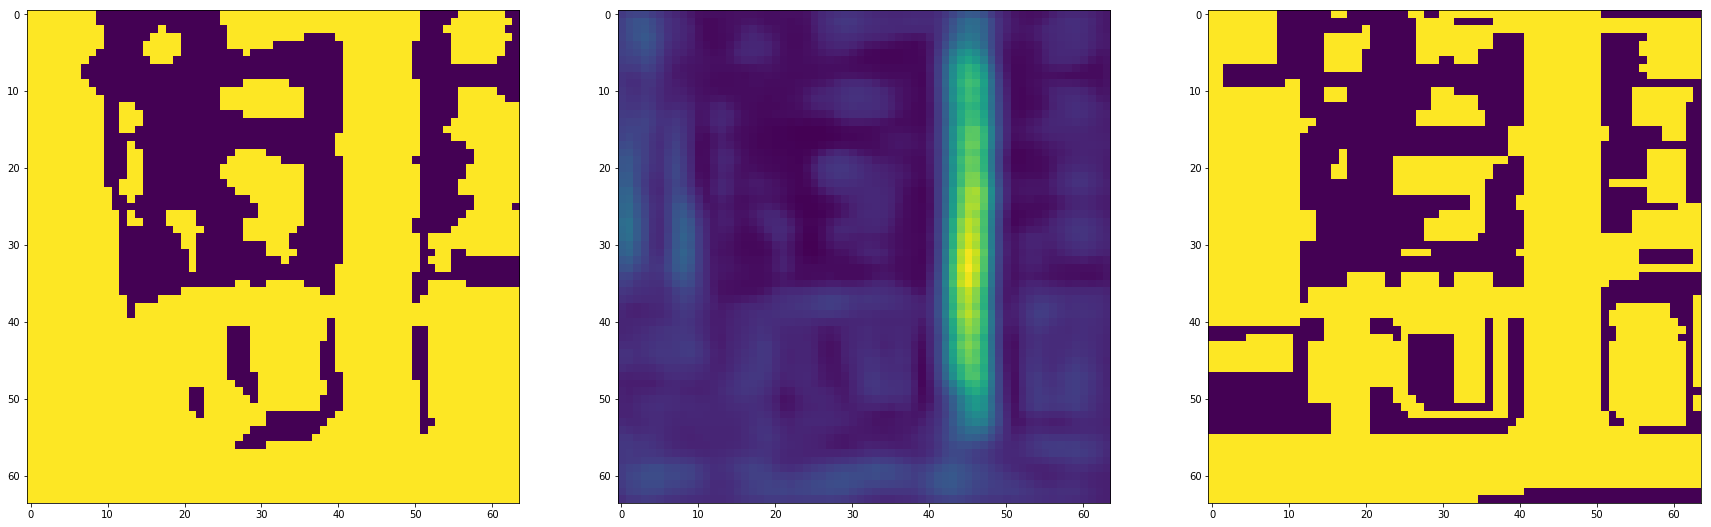

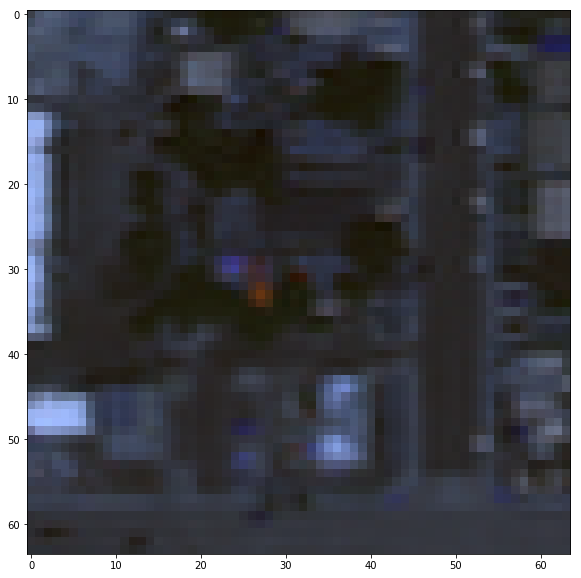

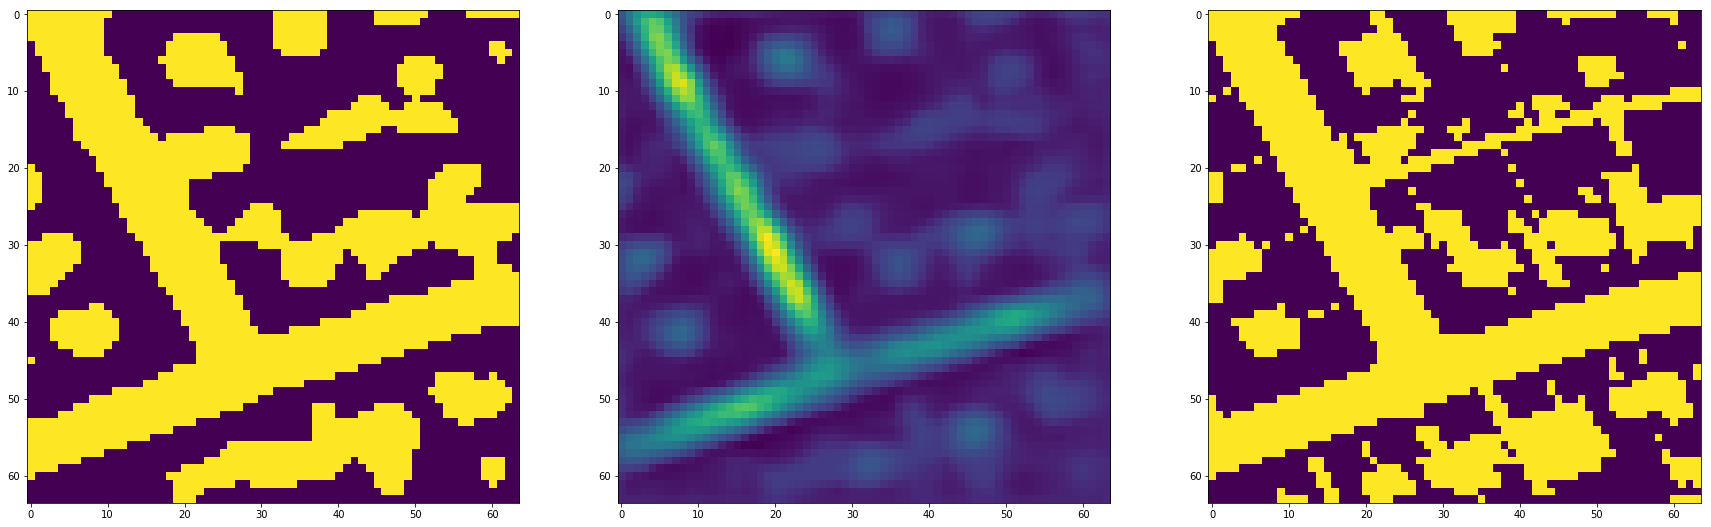

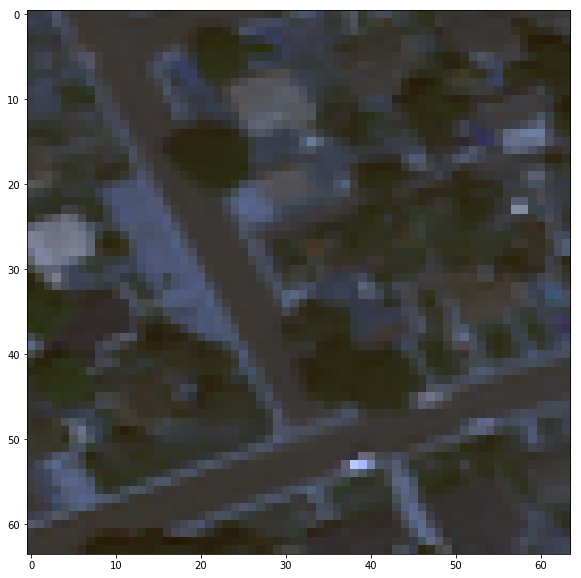

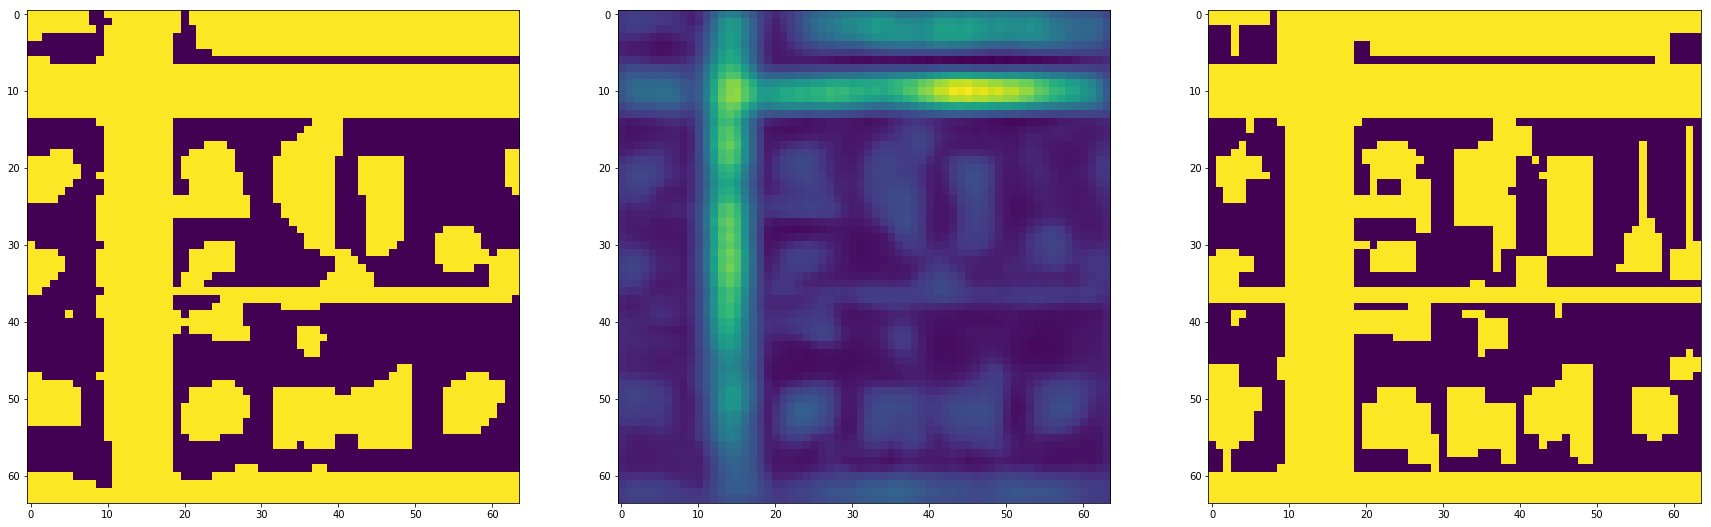

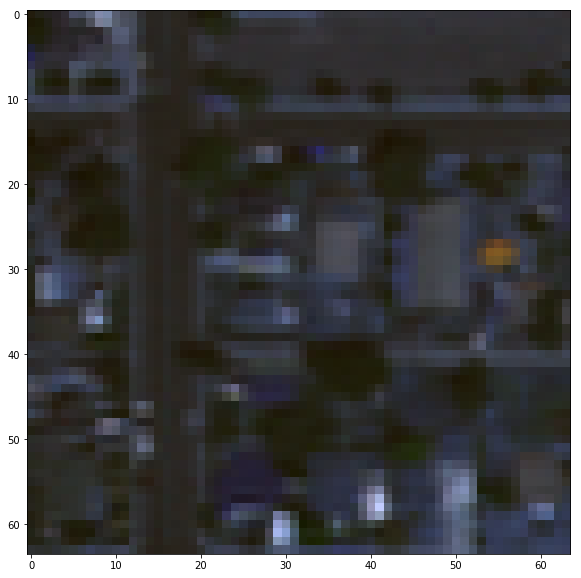

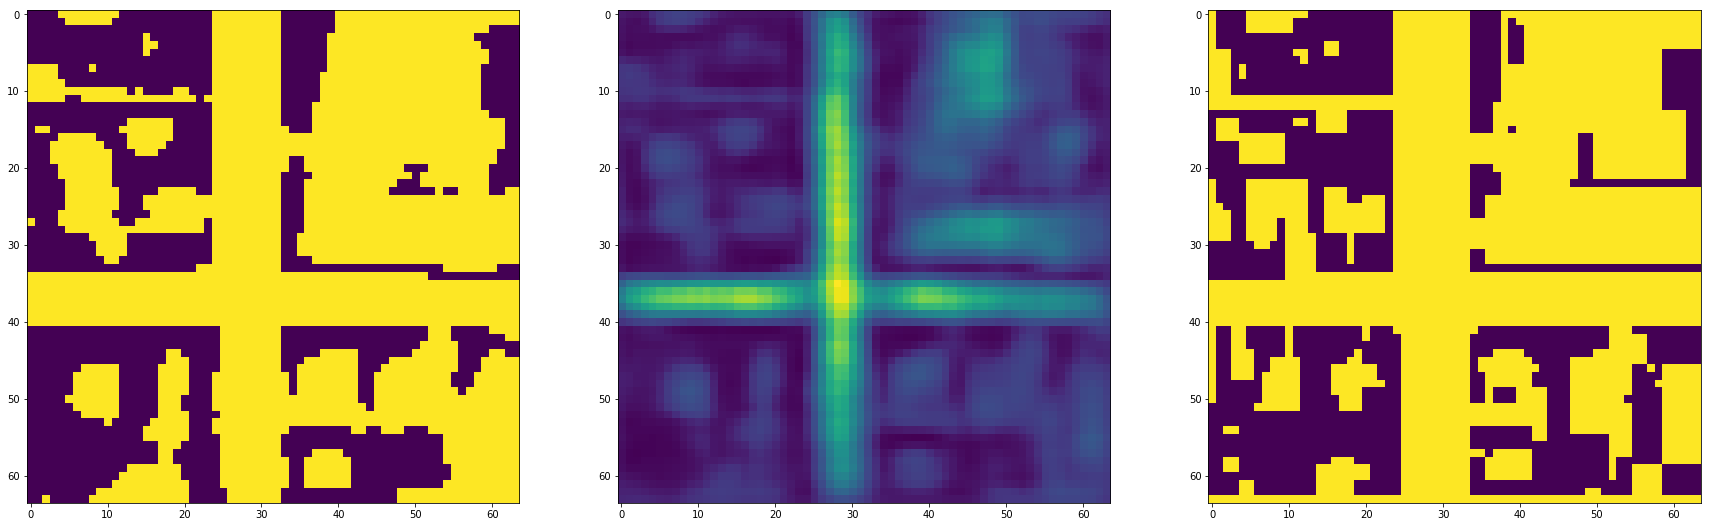

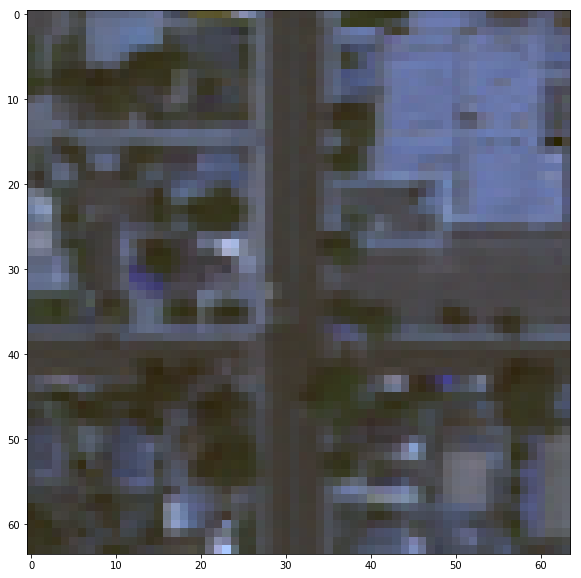

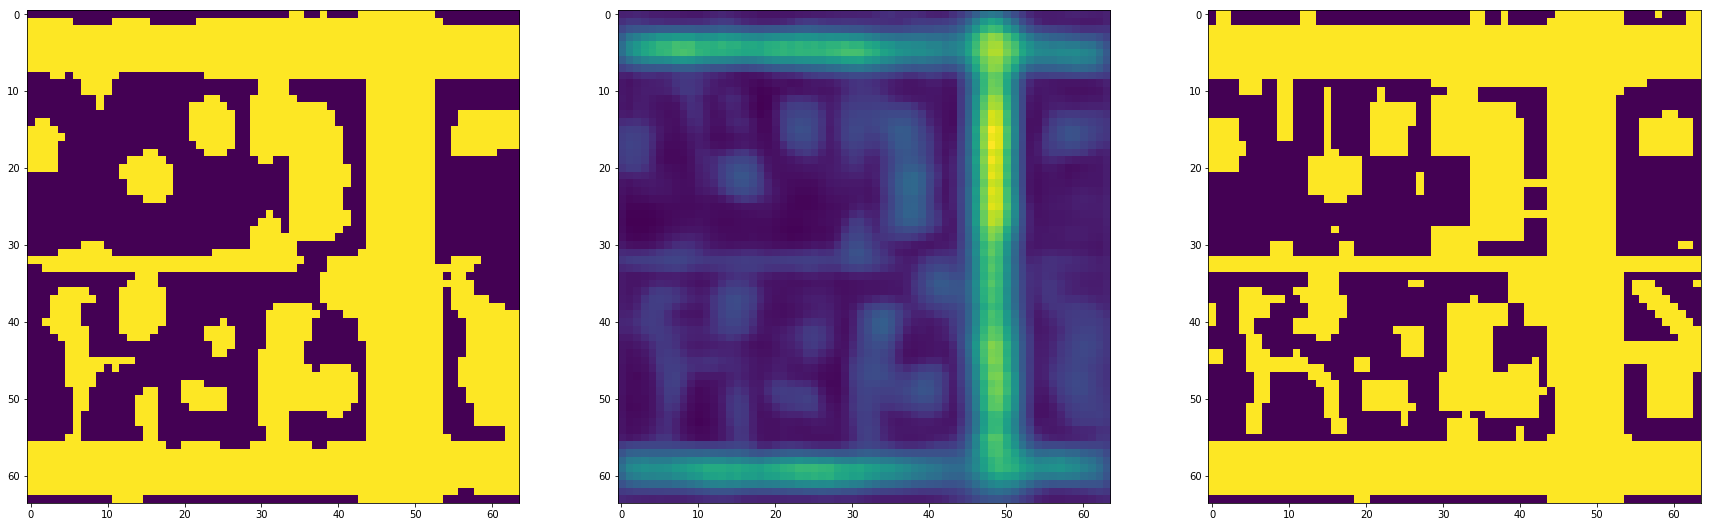

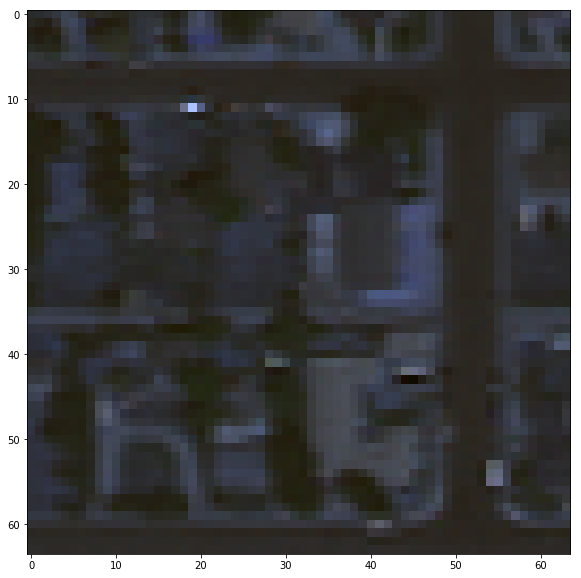

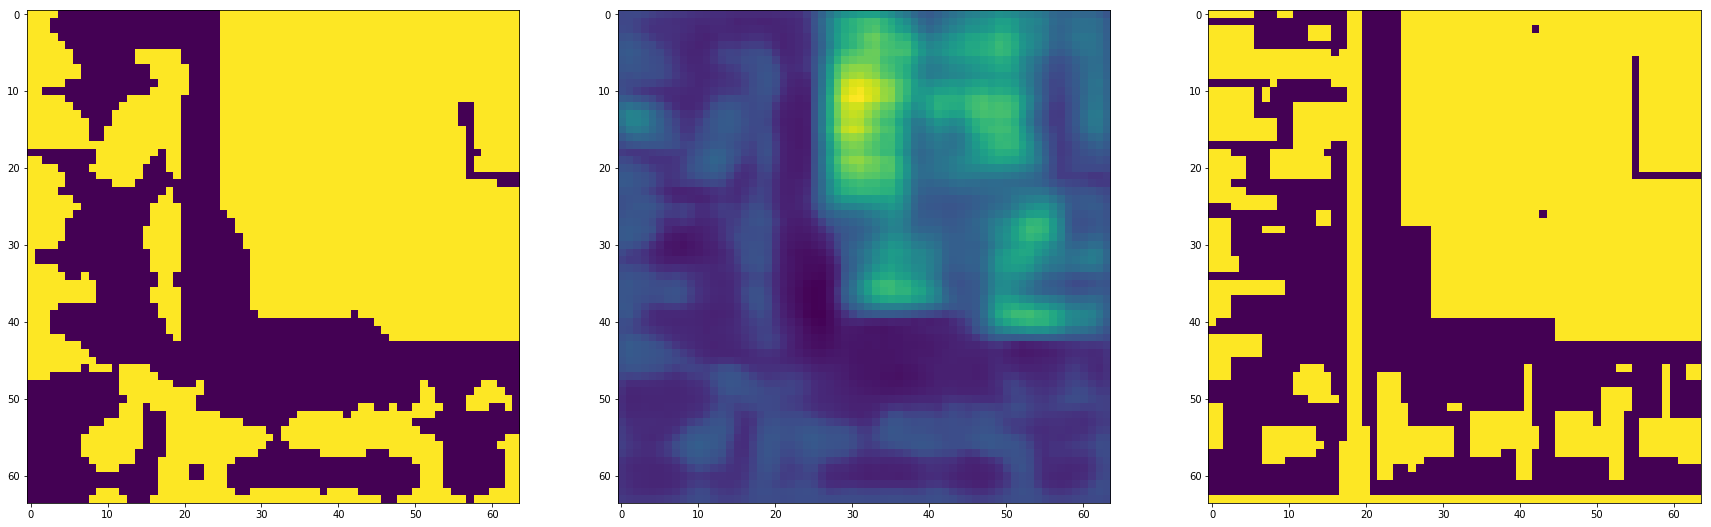

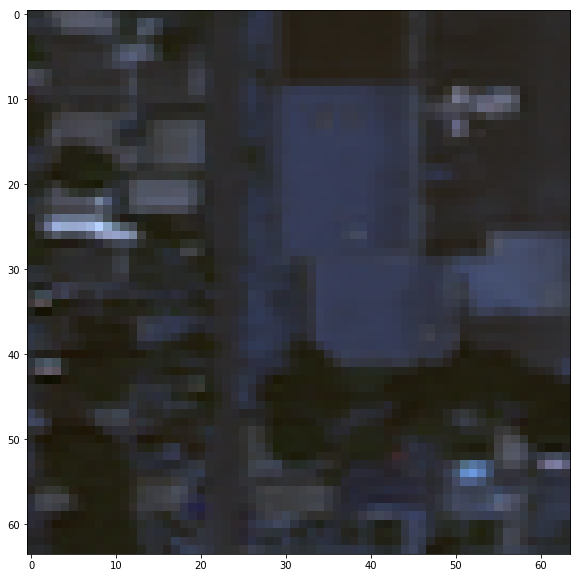

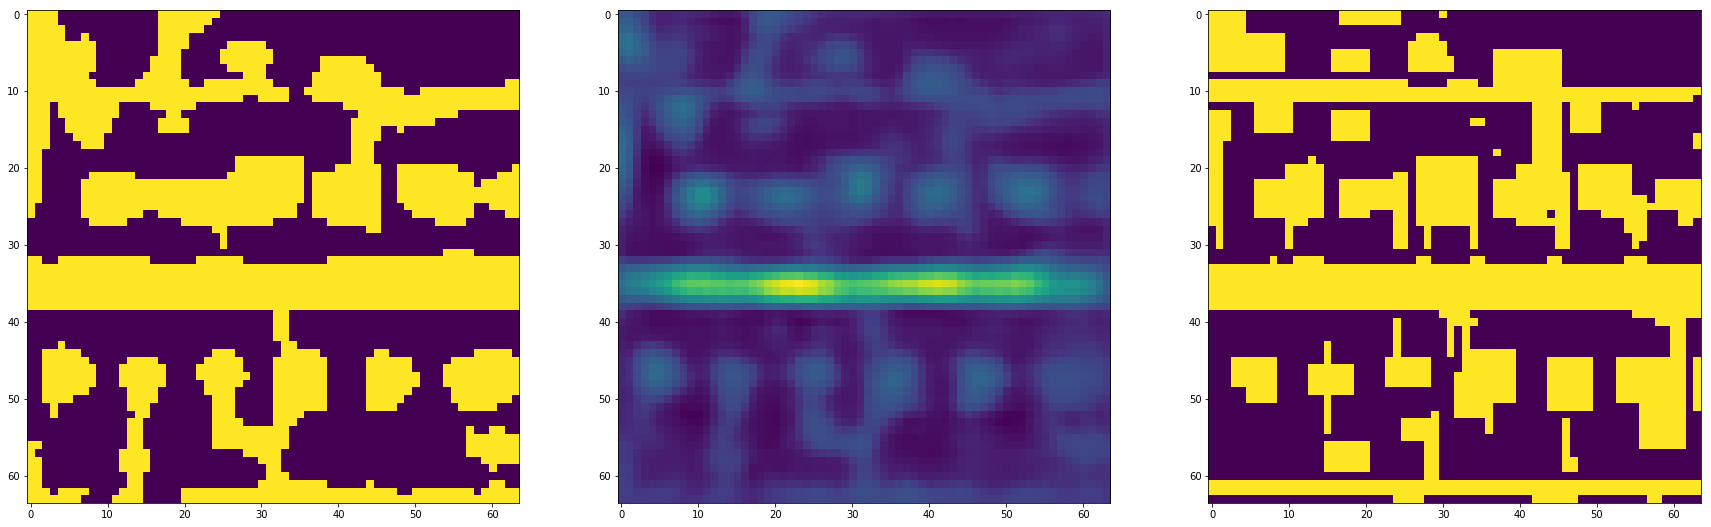

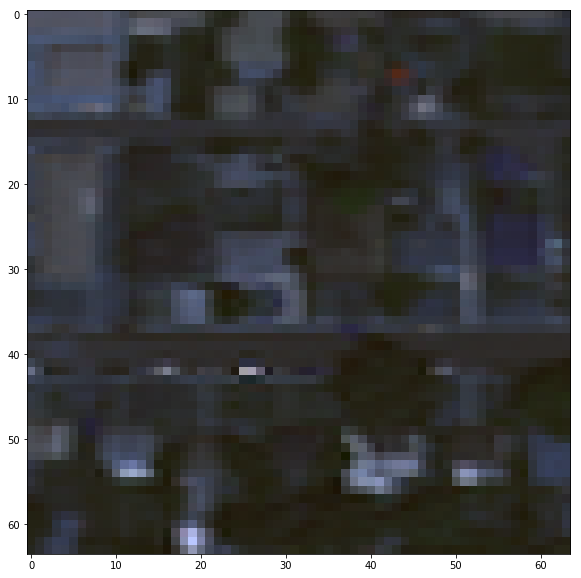

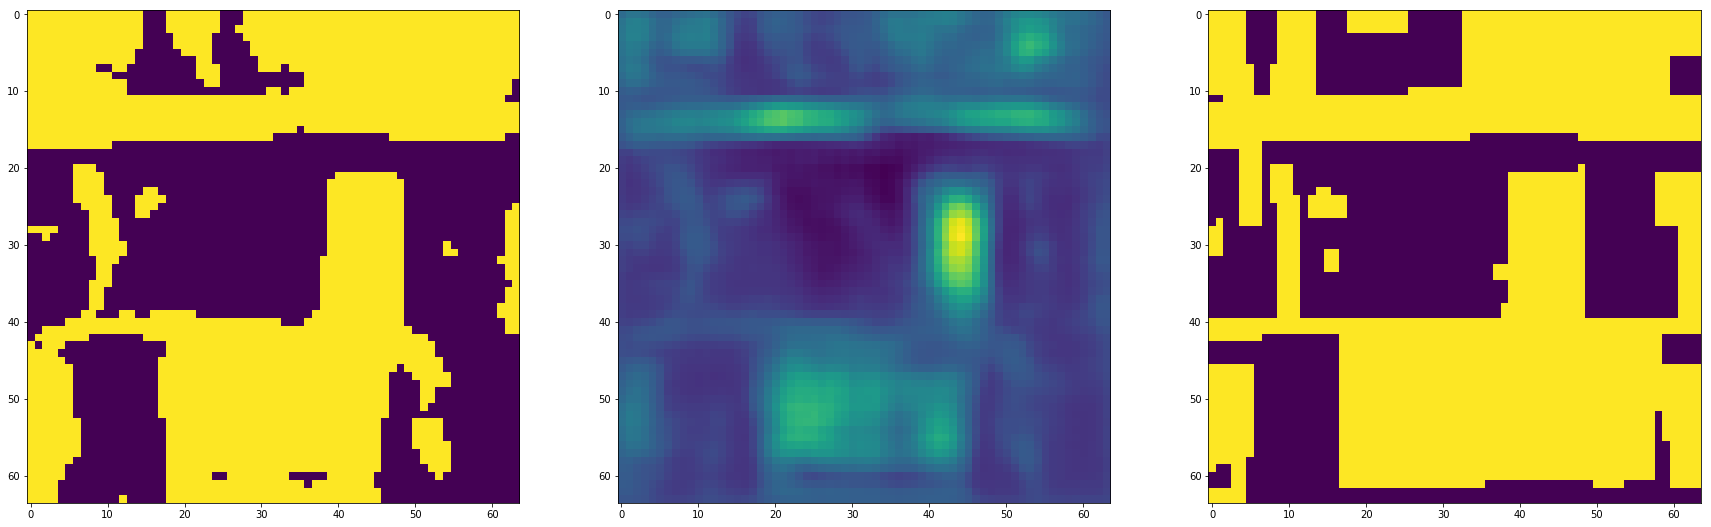

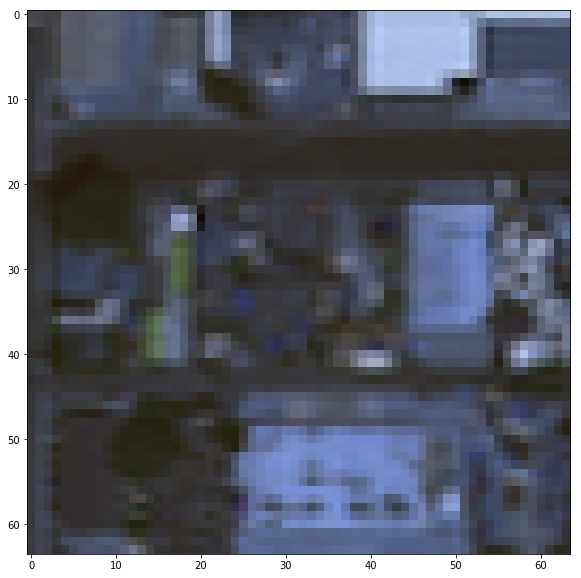

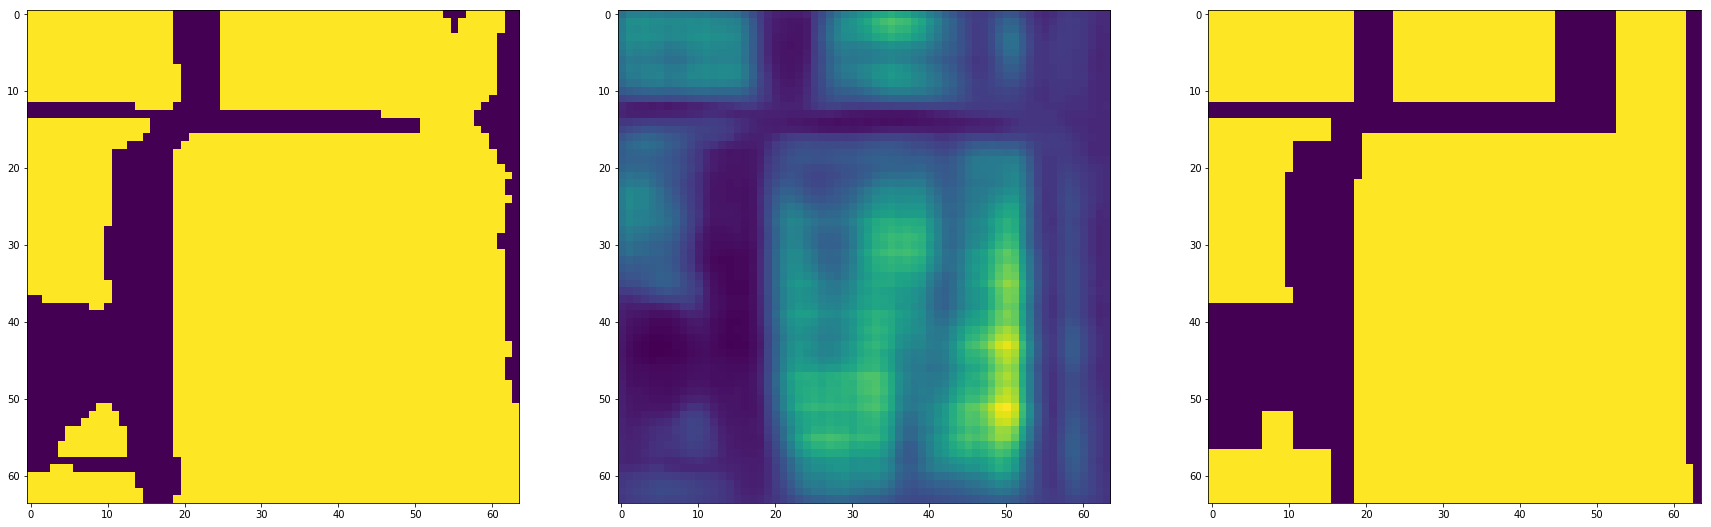

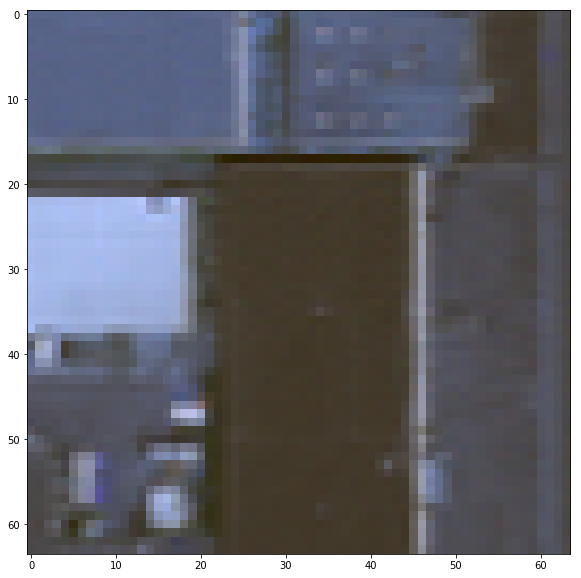

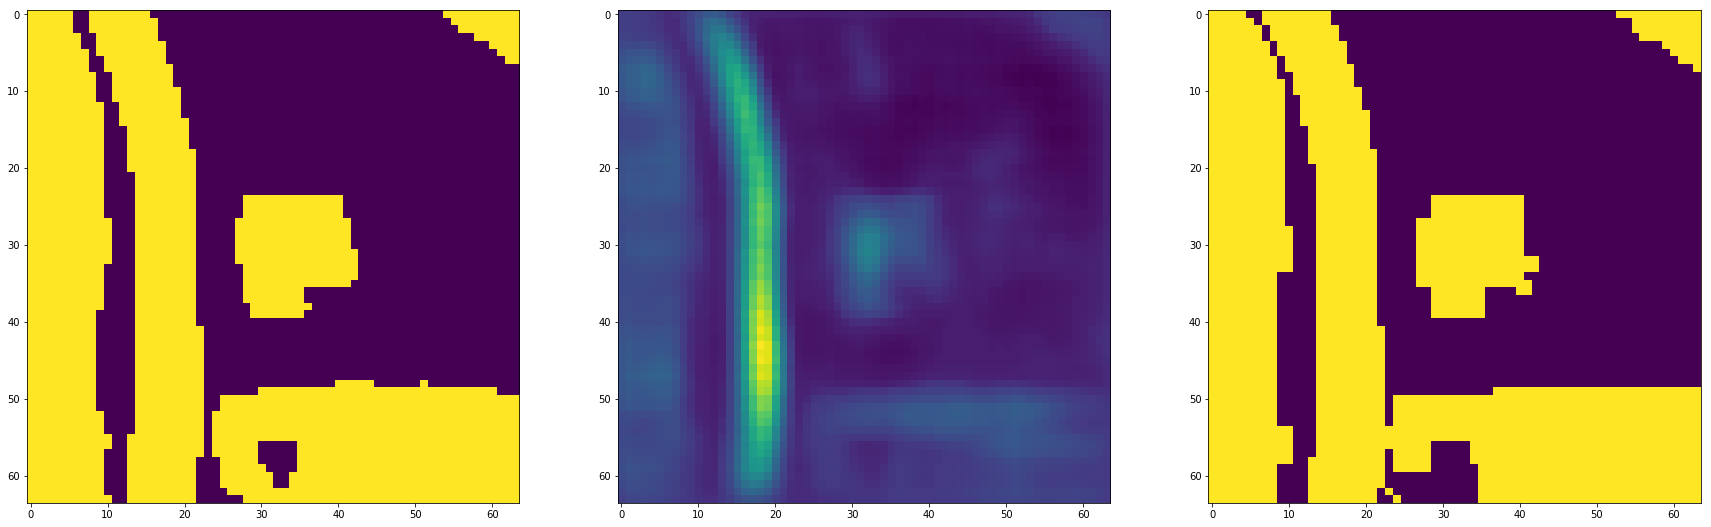

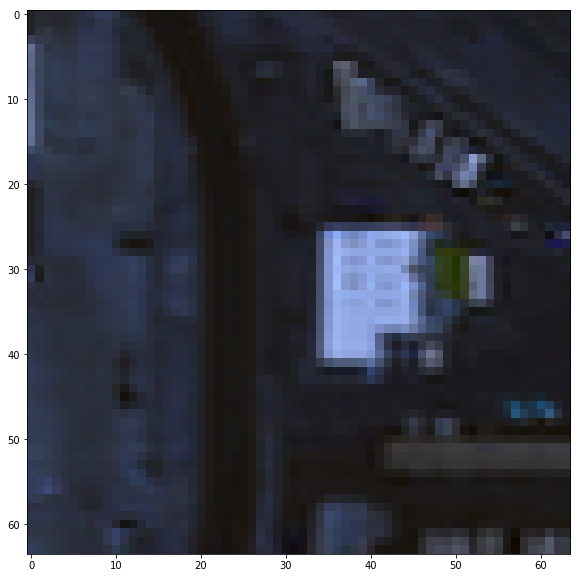

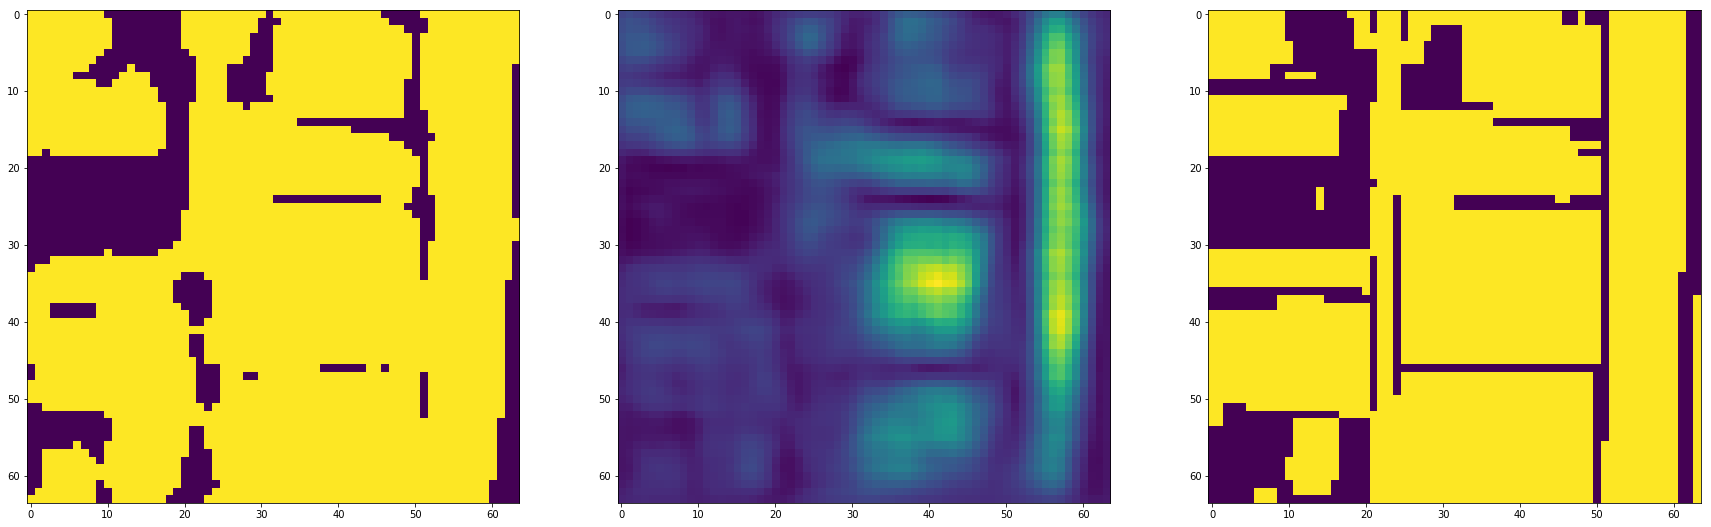

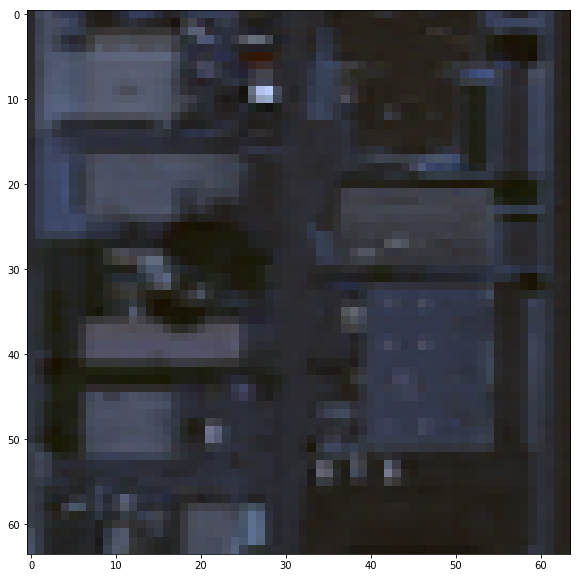

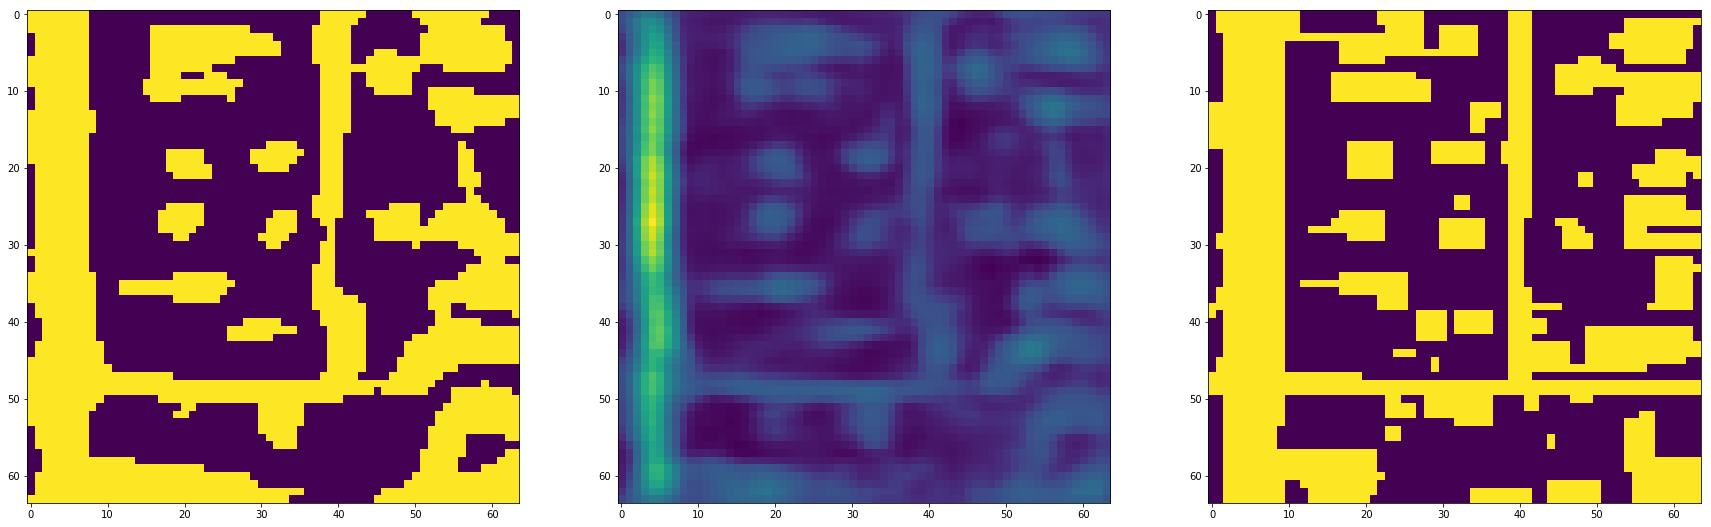

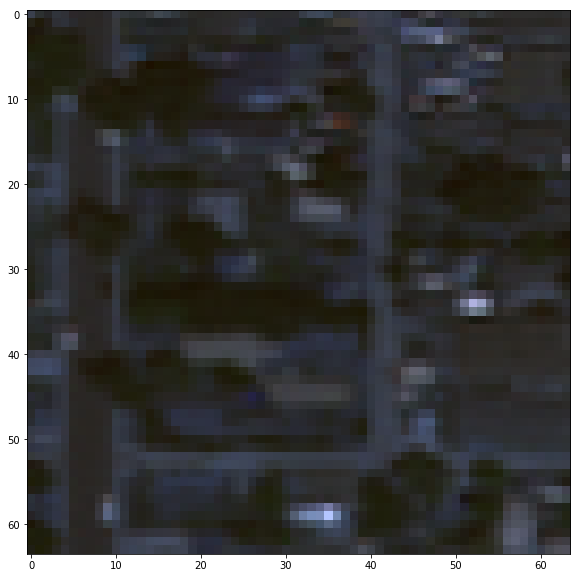

In [23]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
    mask = model(input_img)


    mask_im = mask.squeeze().data.cpu().numpy()
    mask_binary = mask_im.copy()

    fig, ax = plt.subplots(1,3, figsize=(30,10))
    thresh = 0
    mask_binary[mask_im<=thresh] = 0
    mask_binary[mask_im>thresh] = 1
    ax[0].imshow(mask_binary)
    # ax[0].colorbar()
    ax[1].imshow(mask_im)
    gt_im = gt_dataset_test[test_ind].numpy().squeeze()
    ax[2].imshow(gt_im)
    # ax[1].colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    source_im = dg_dataset_test[test_ind].numpy()
    plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
    plt.show()



In [24]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [25]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [26]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))